Current directory: c:\Dilan\Study\Master Thesis\Characterization\XRD\30-09-2025 Dep No 1


C:\Users\Dilan\AppData\Local\Temp\ipykernel_19892\924595664.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,5))


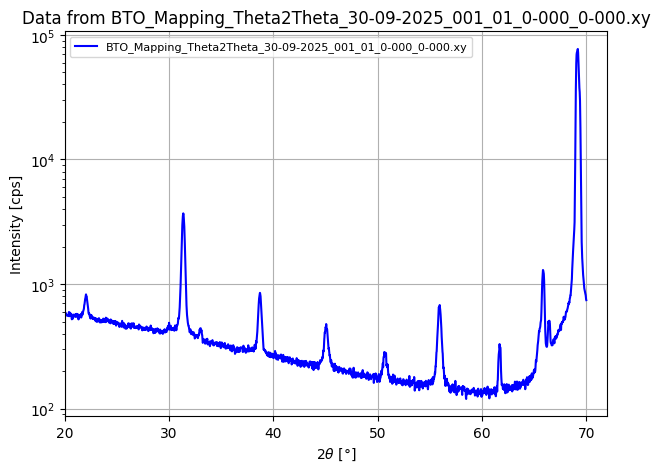

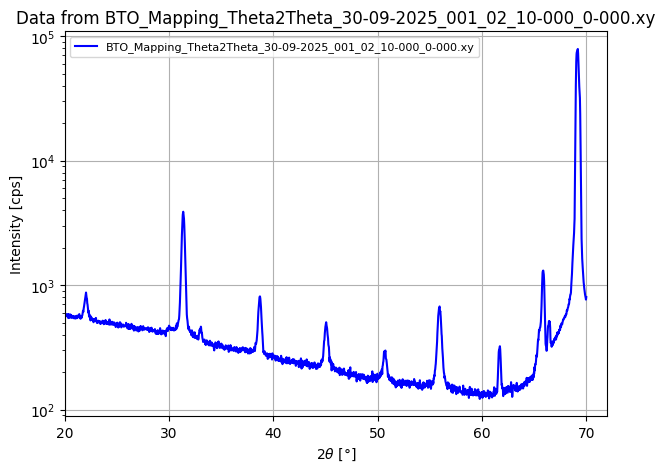

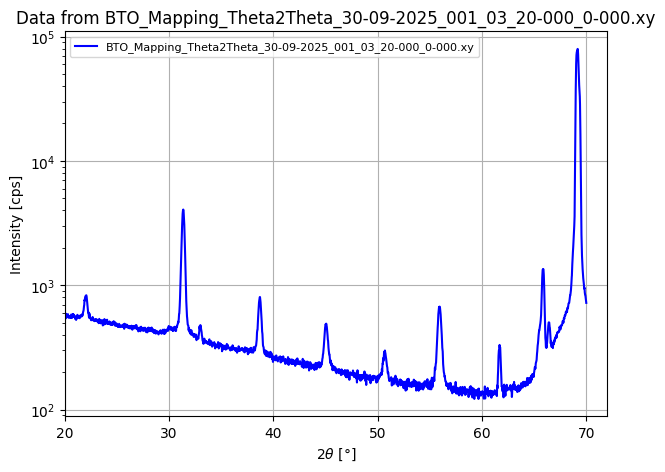

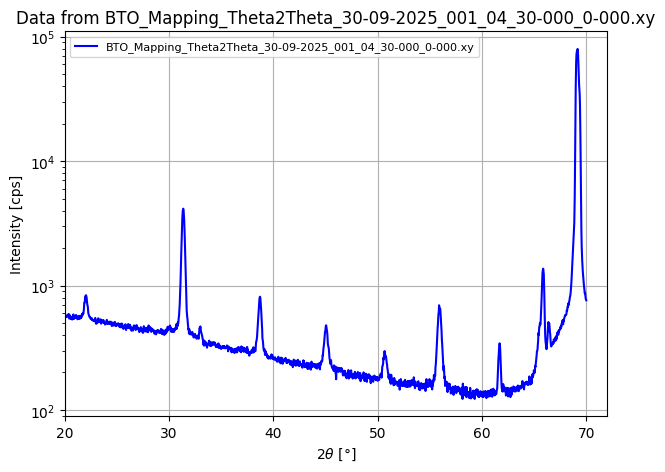

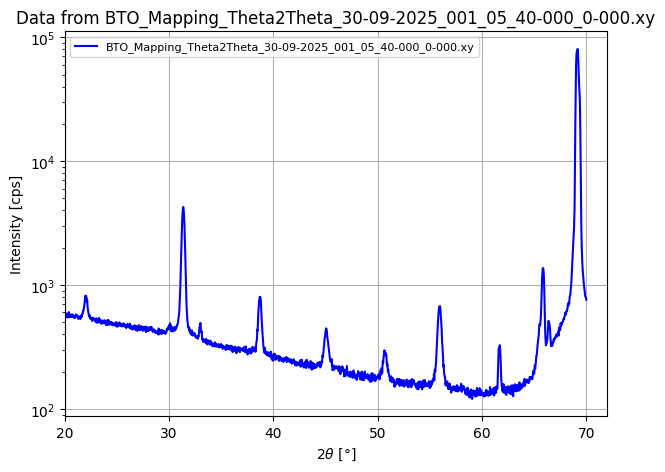

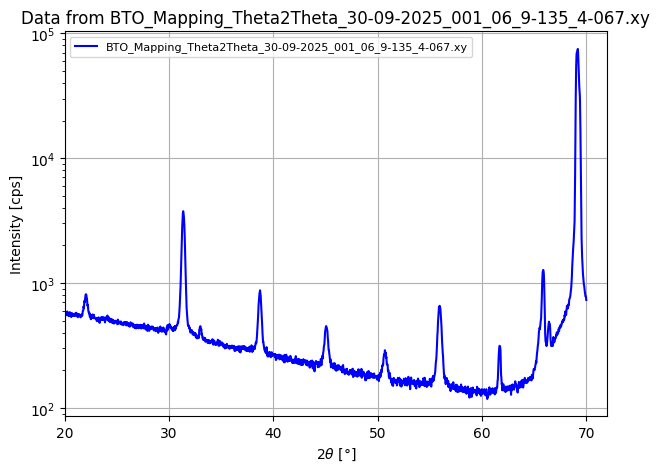

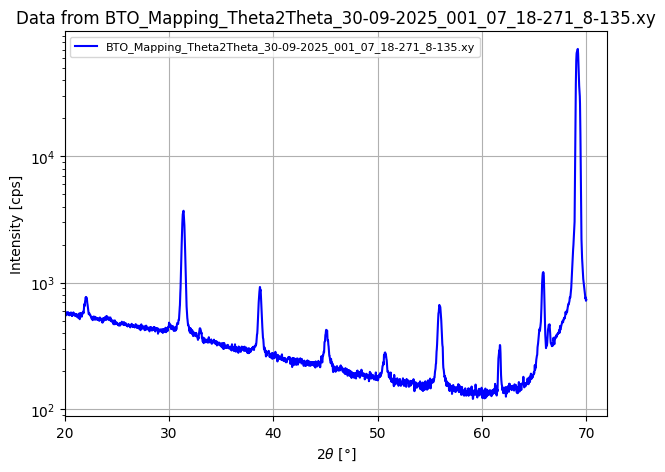

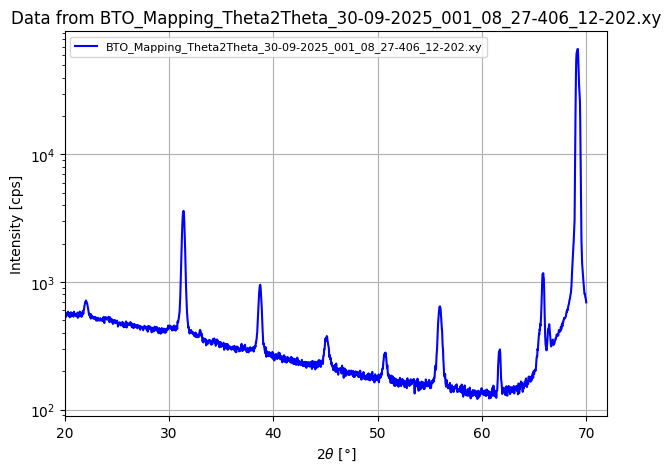

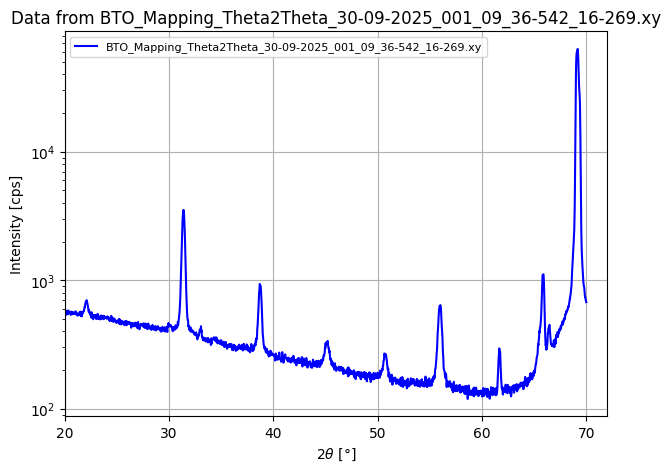

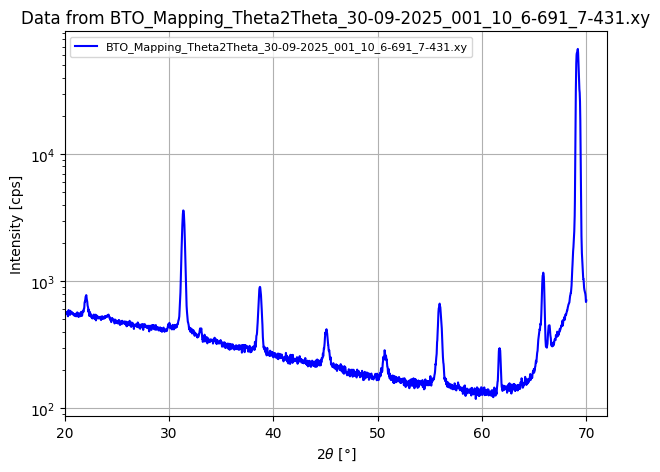

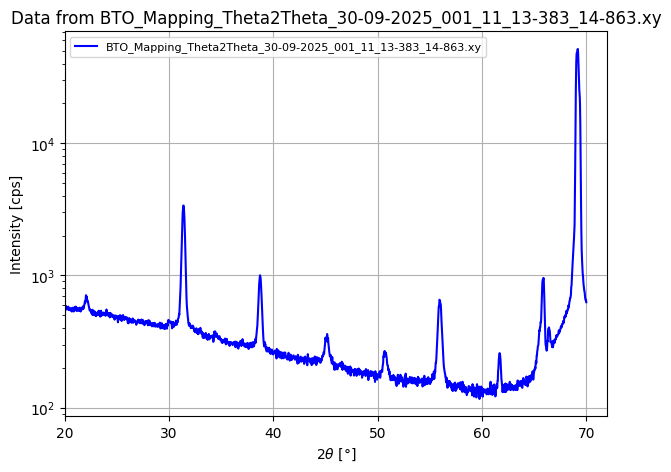

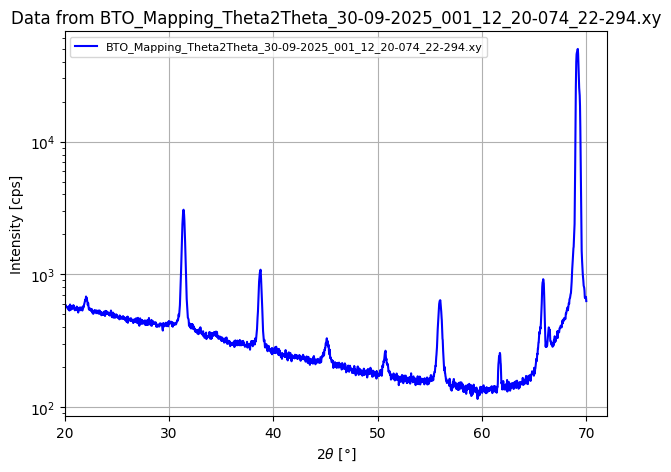

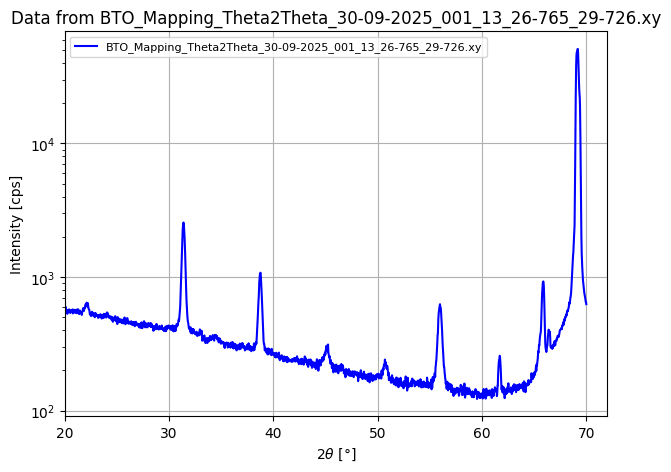

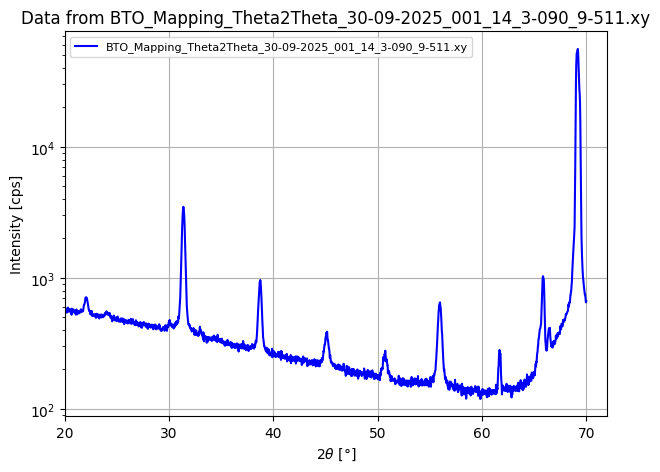

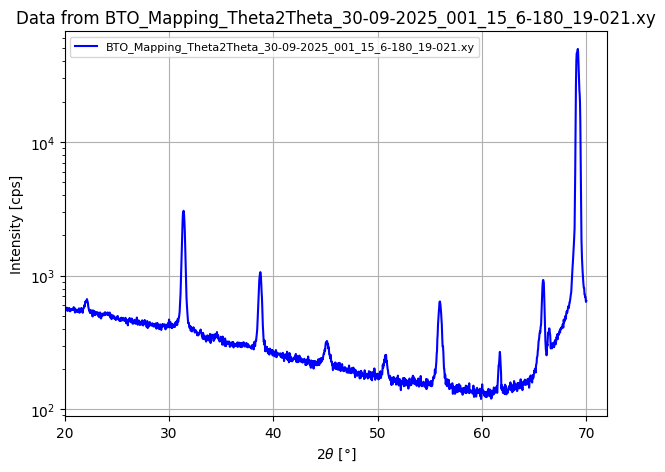

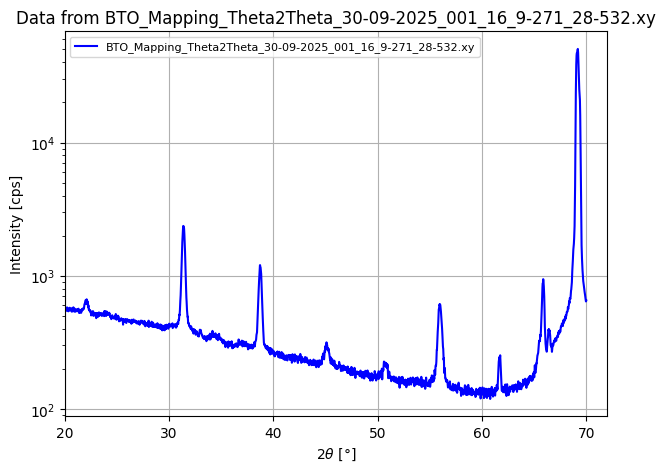

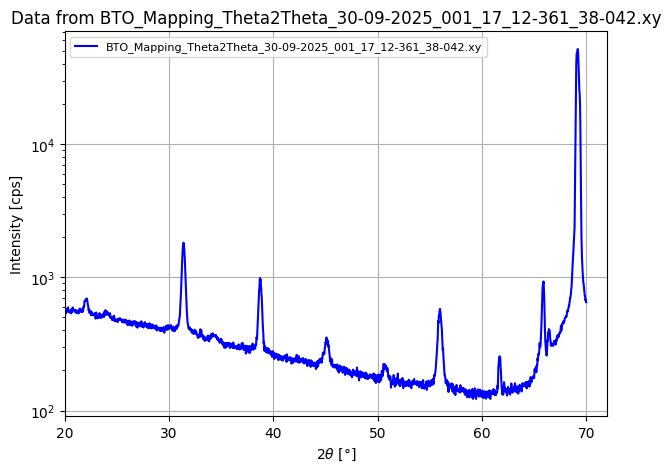

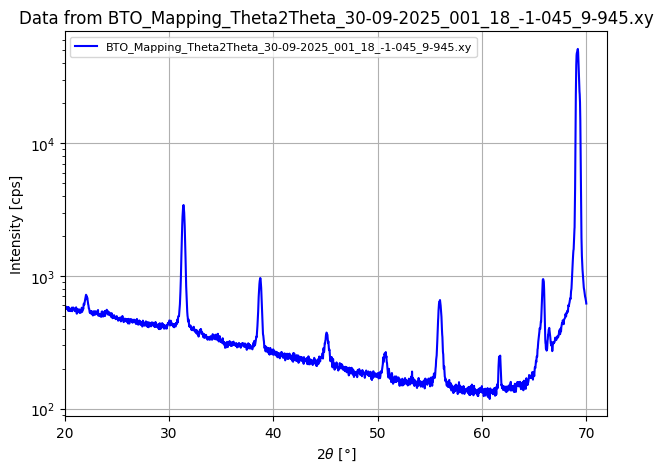

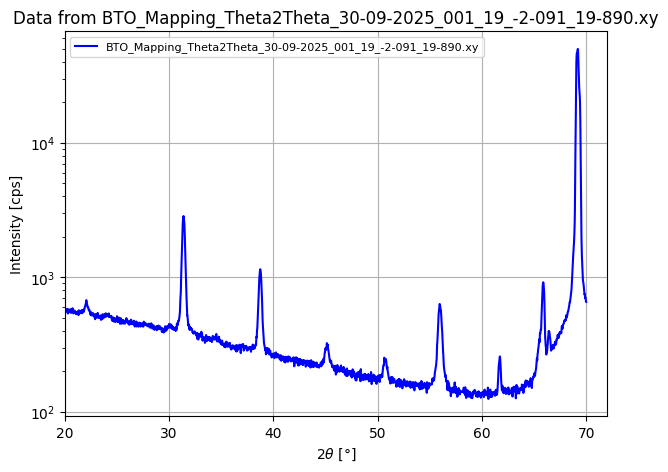

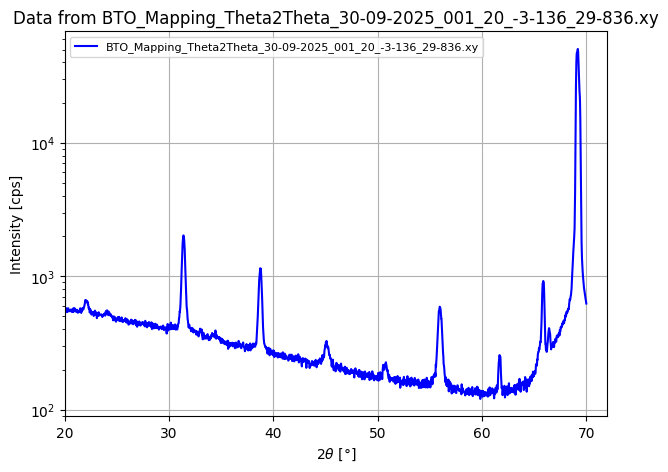

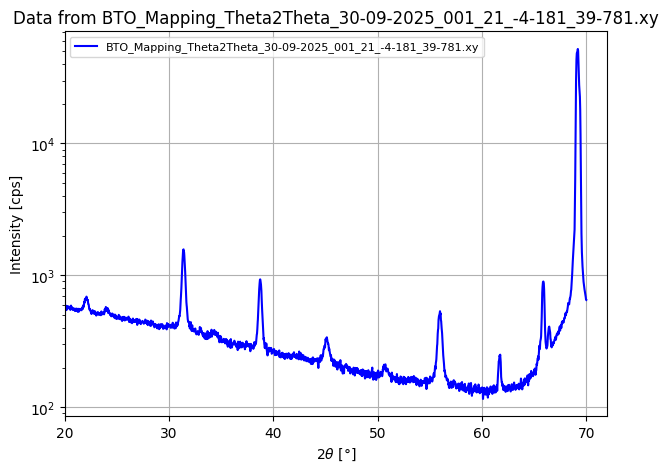

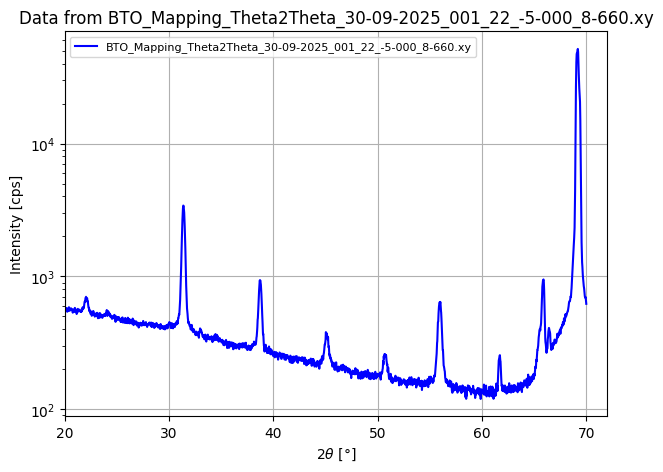

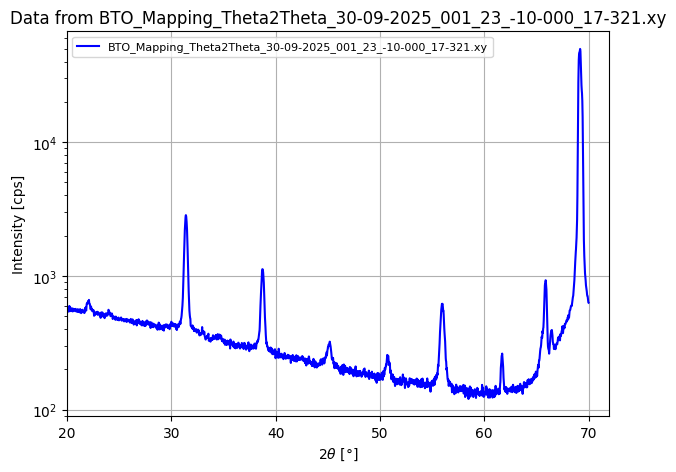

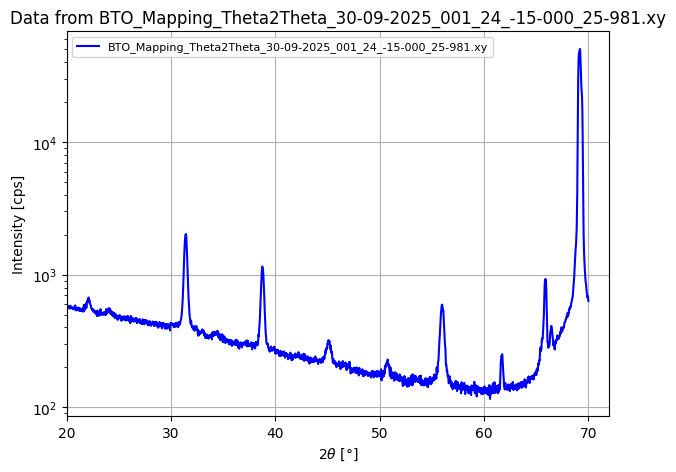

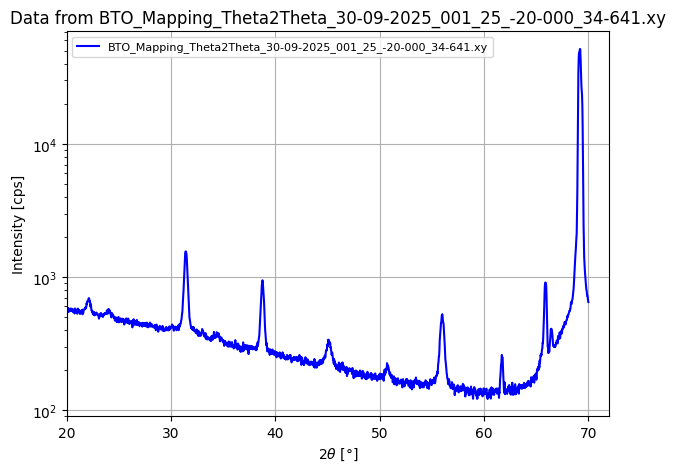

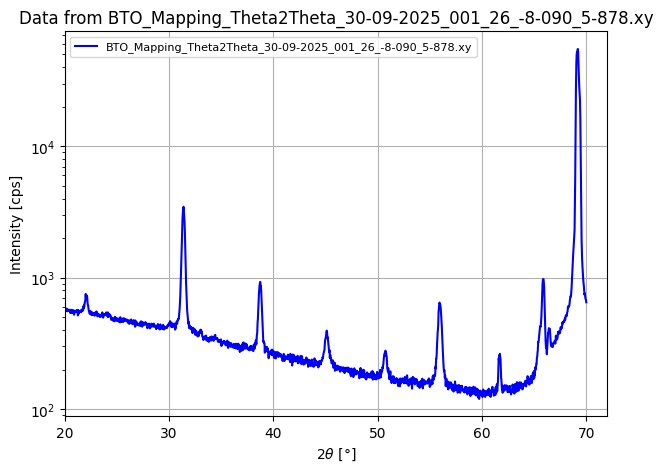

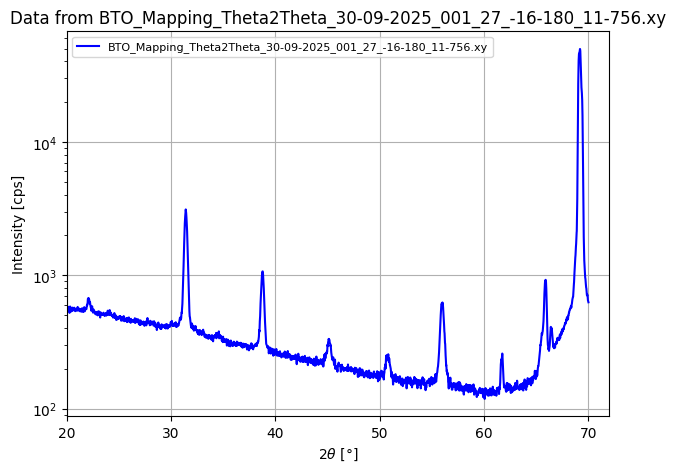

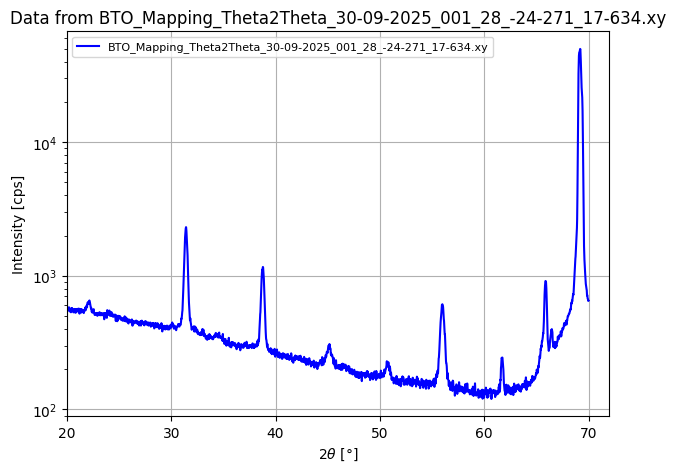

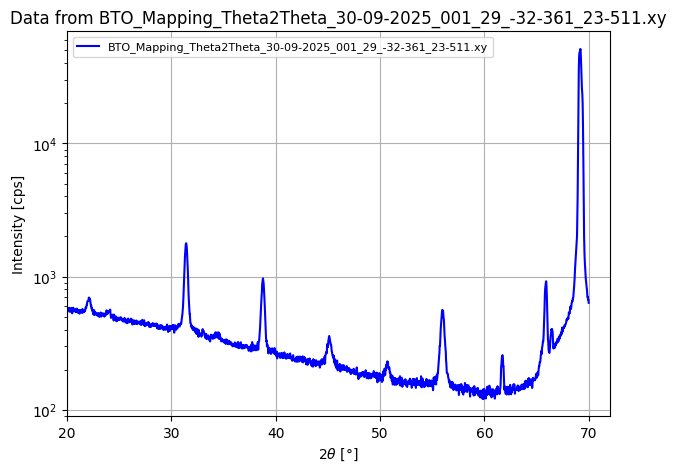

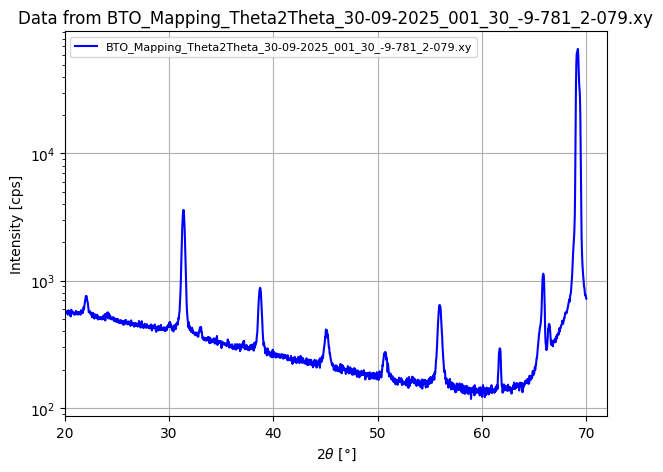

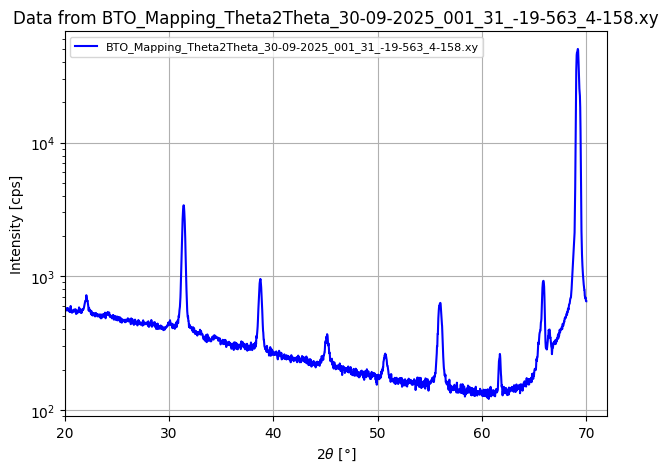

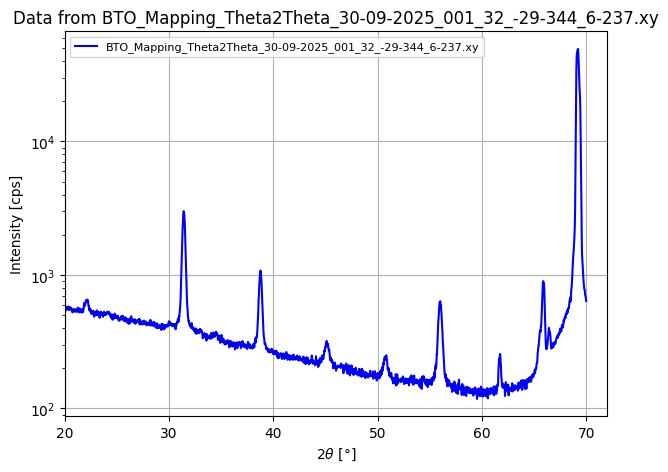

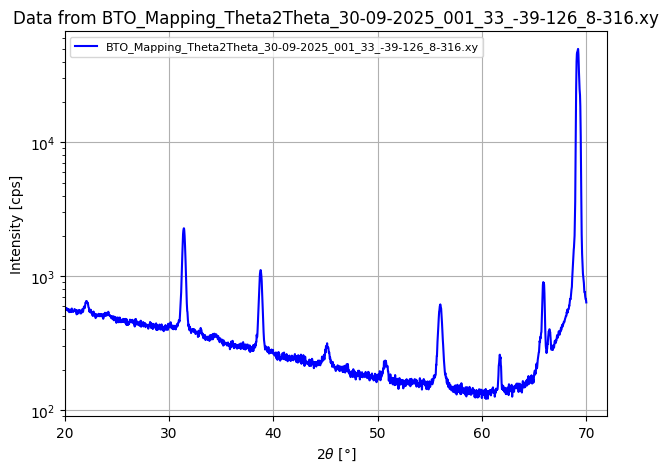

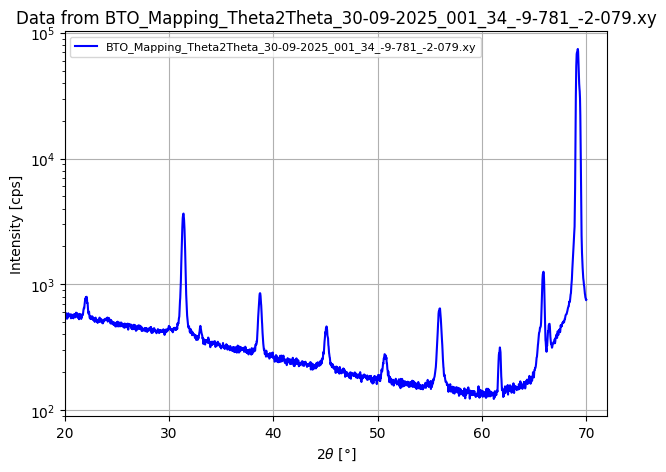

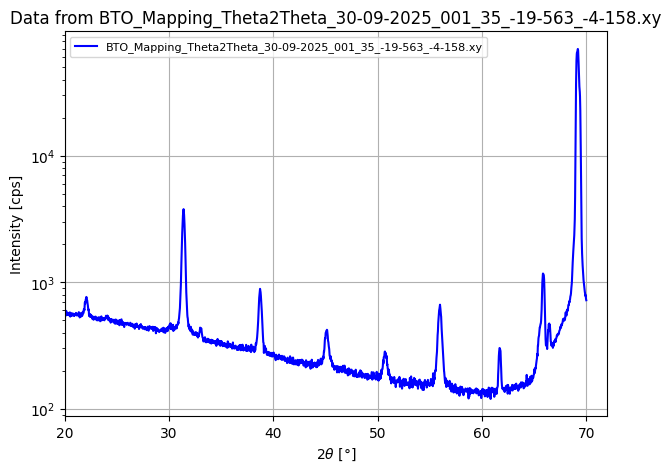

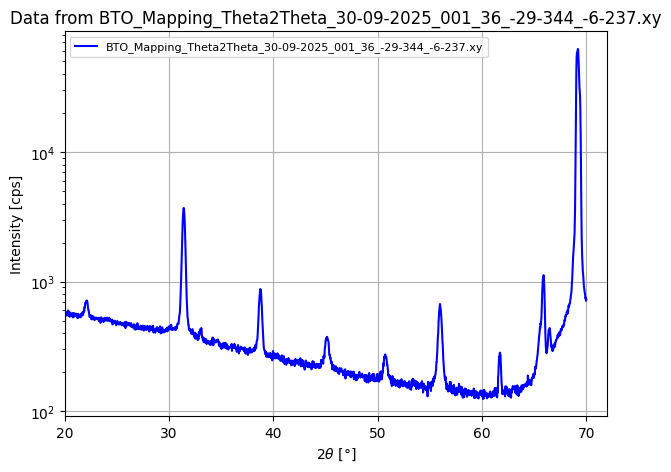

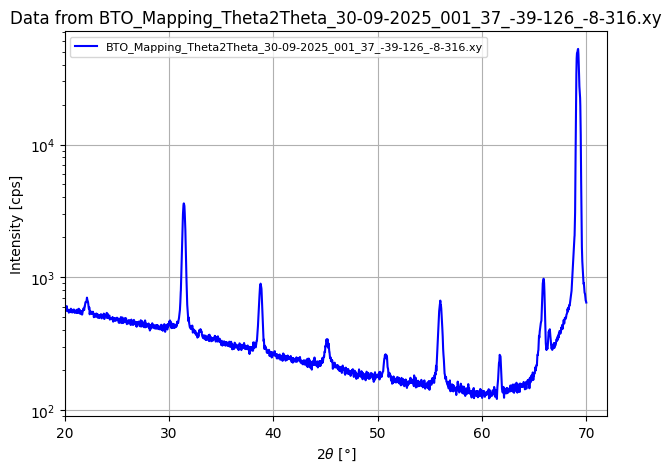

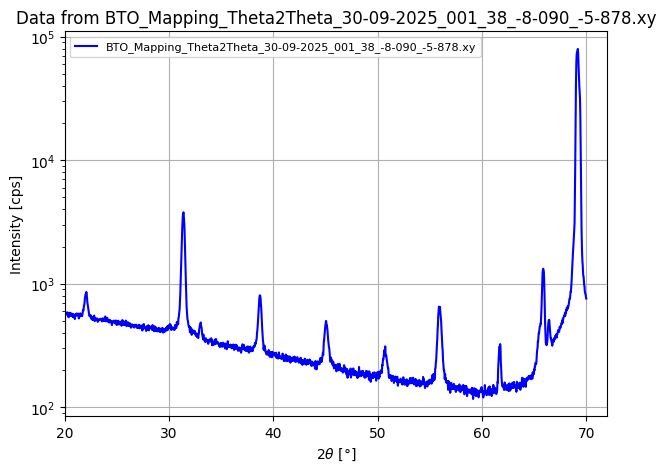

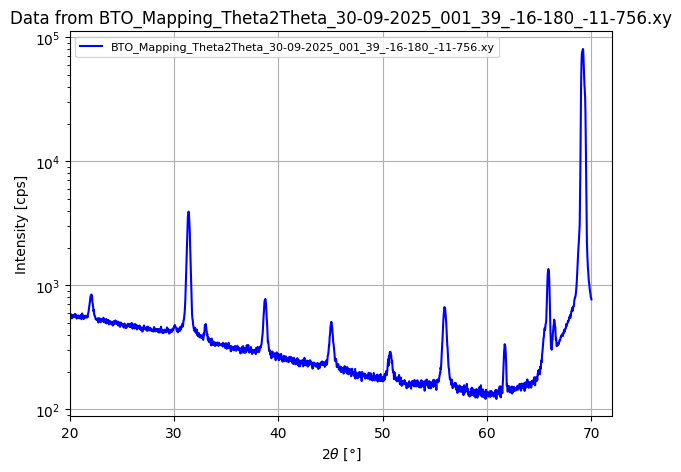

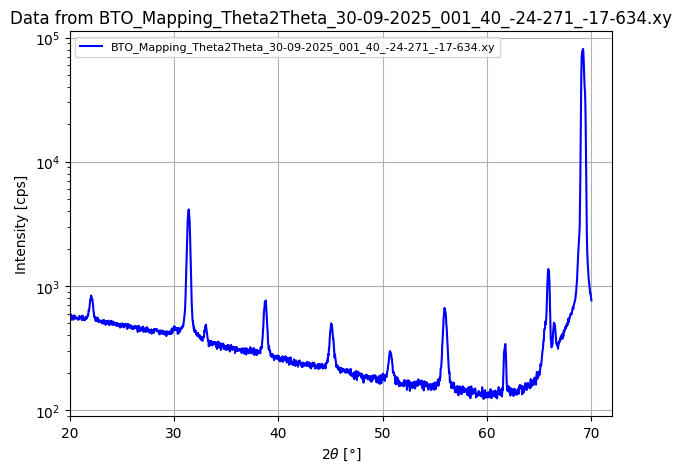

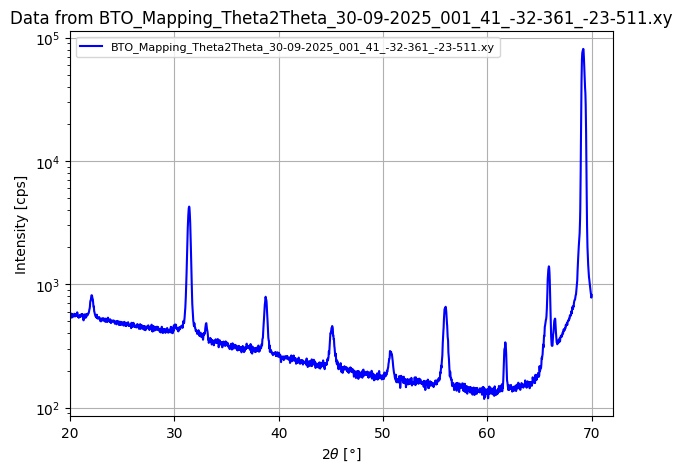

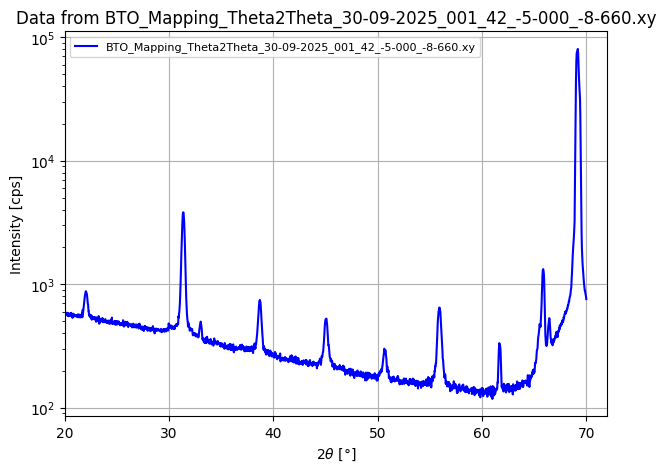

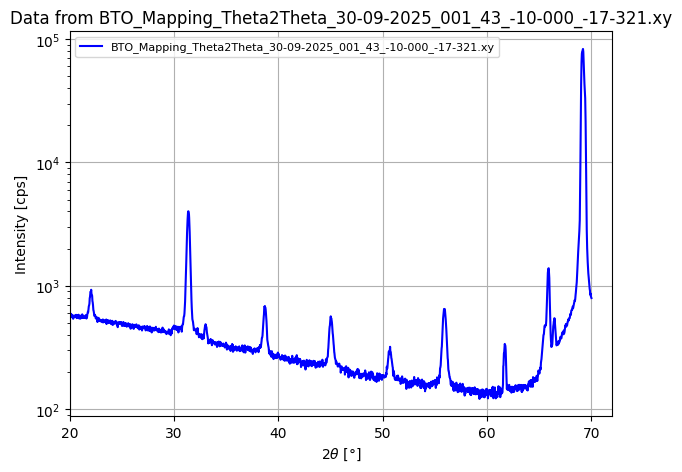

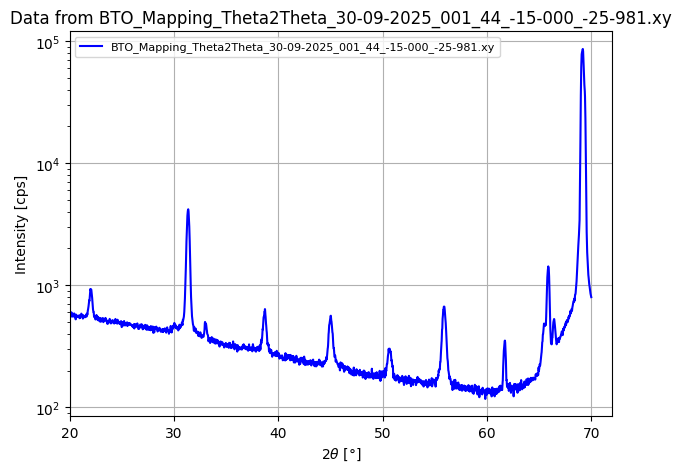

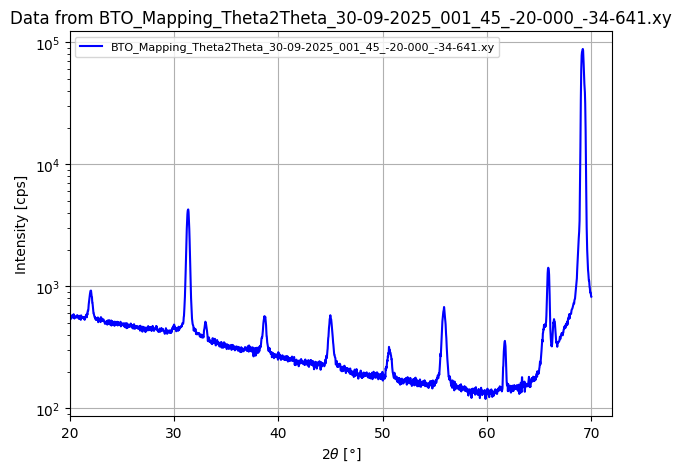

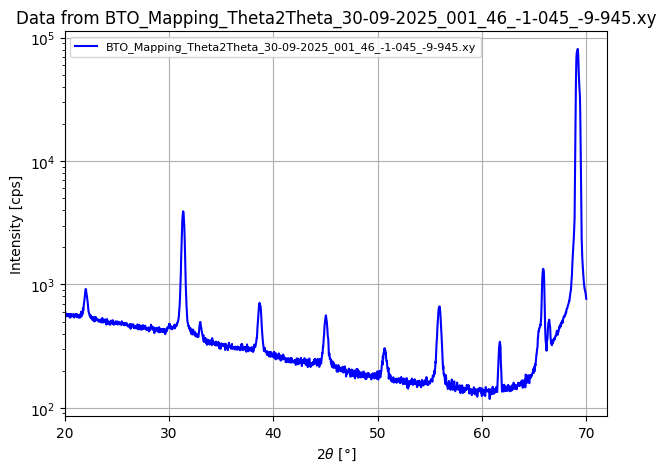

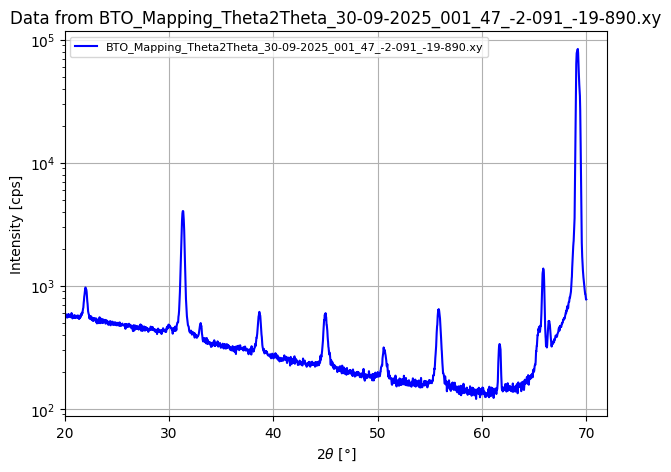

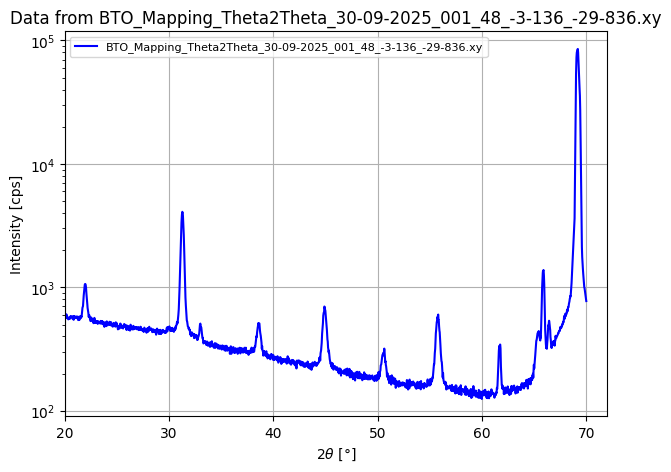

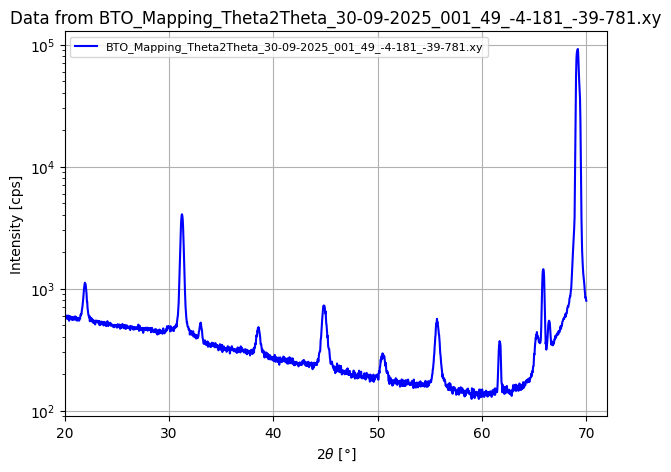

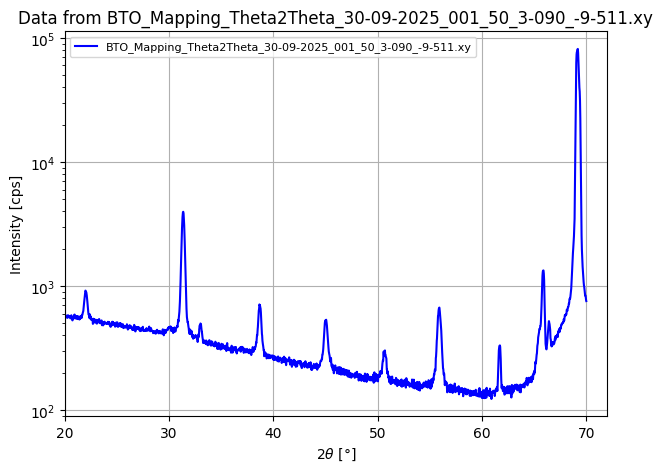

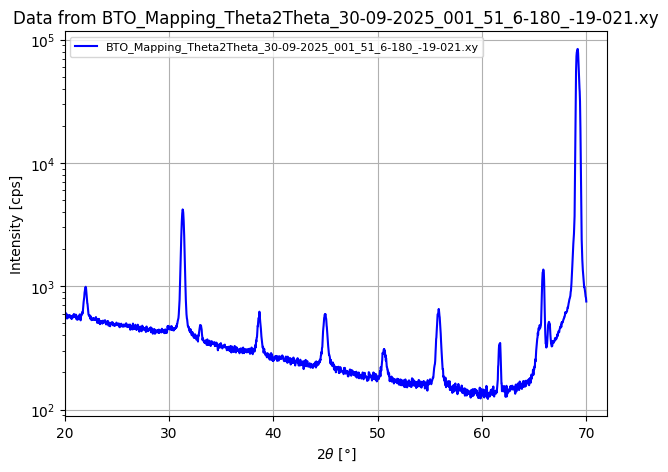

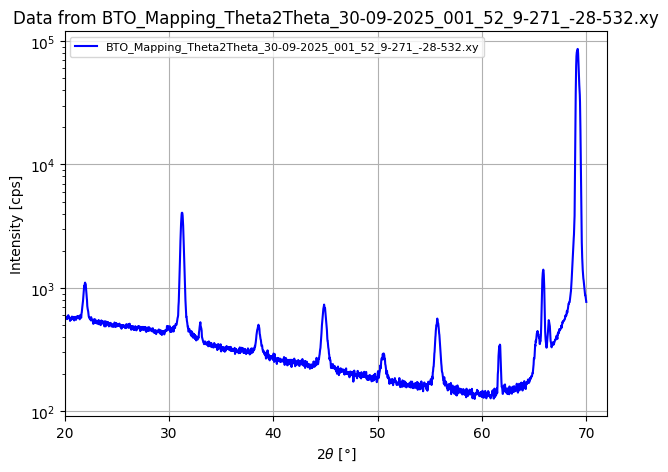

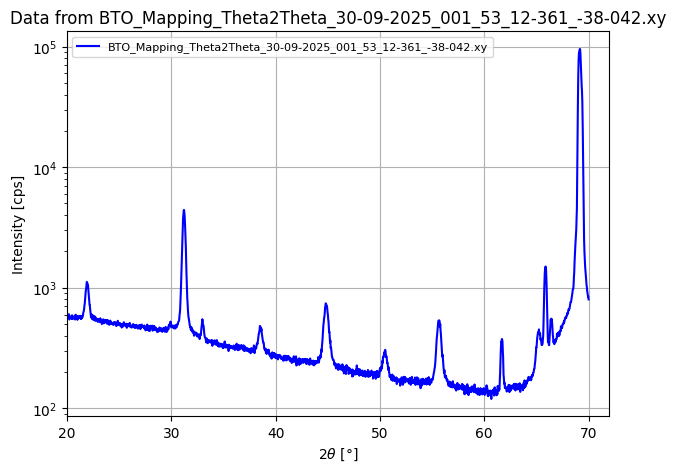

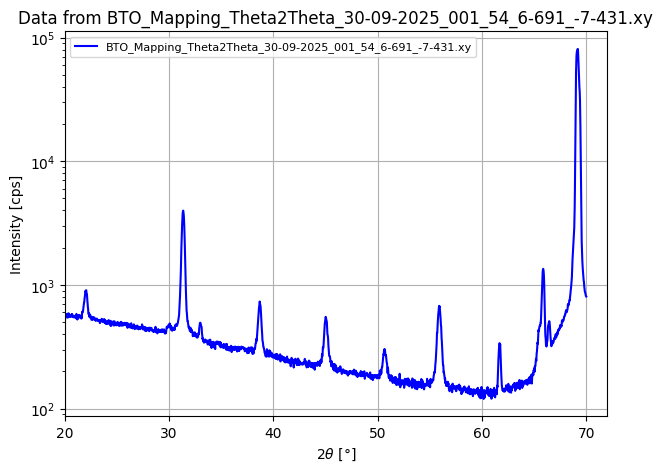

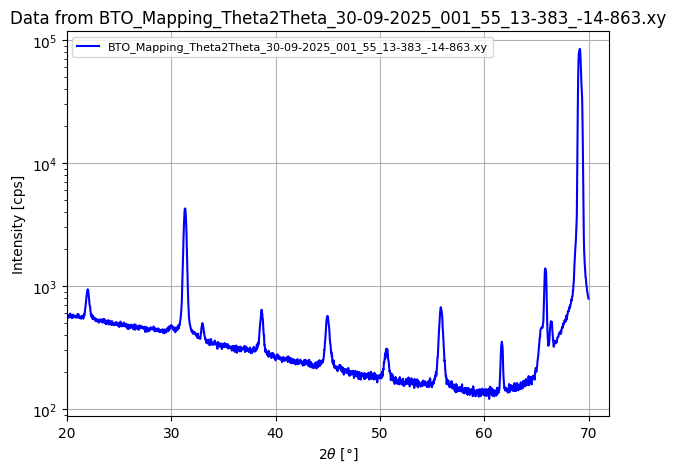

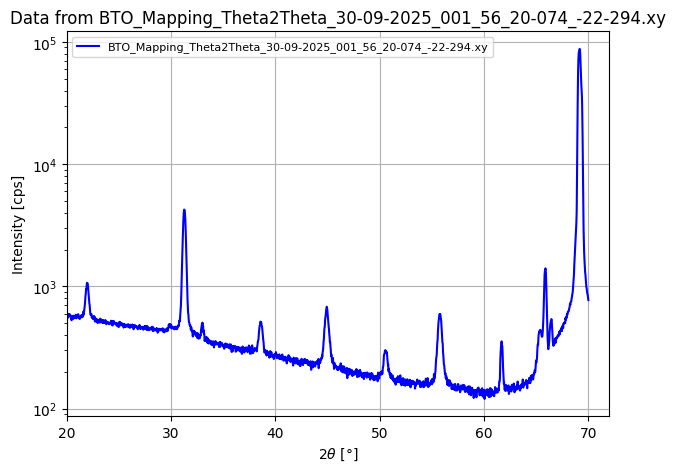

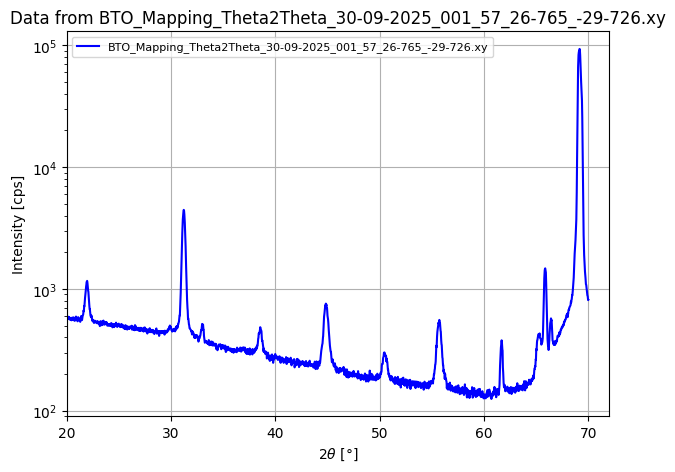

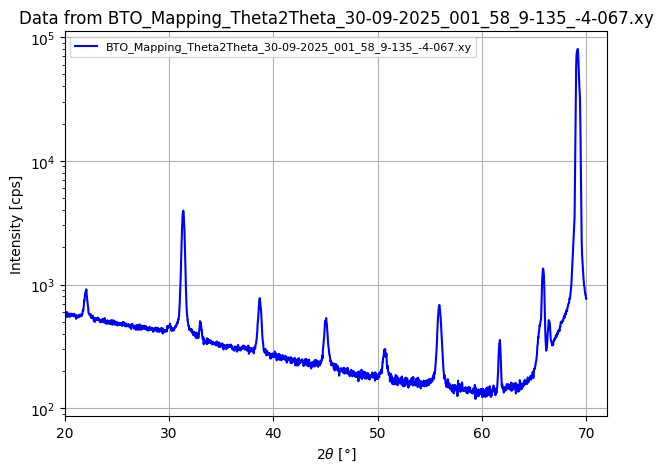

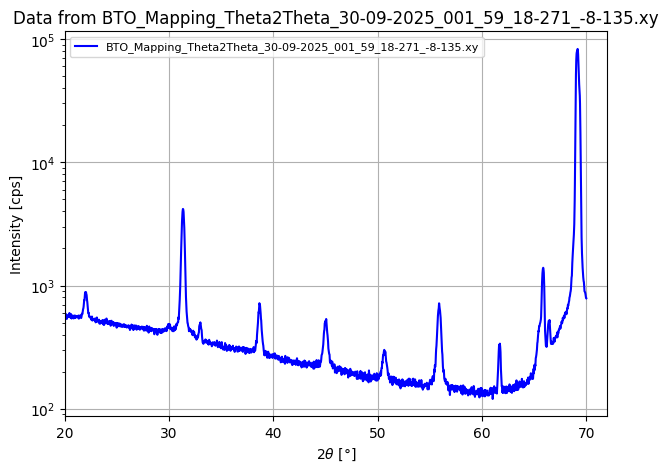

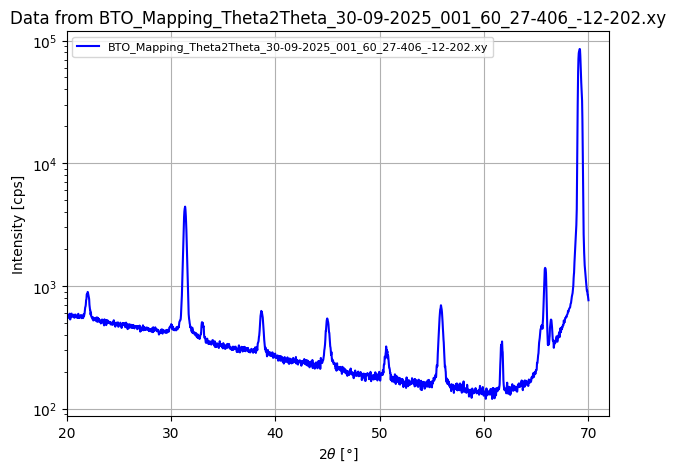

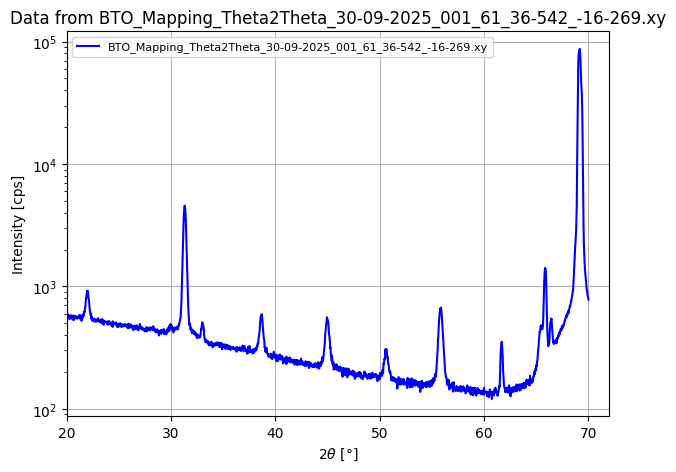

In [3]:
import pandas as pd
import numpy as np
import os, glob, re, csv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, savgol_filter
from scipy.optimize import curve_fit
from matplotlib.tri import Triangulation
from matplotlib.colors import LinearSegmentedColormap, PowerNorm  # or Normalize


# Show current working directory
print("Current directory:", os.getcwd())

# Change working directory
os.chdir("C:\\Dilan\\Study\\Master Thesis\\Characterization\\XRD\\30-09-2025 Dep No 1")

folder = "C:\\Dilan\\Study\\Master Thesis\\Characterization\\XRD\\30-09-2025 Dep No 1\\XY Data"
os.chdir(folder)

files = glob.glob("*.xy")



# Loop over each file and make a separate graph
for f in files:
    df = pd.read_csv(f, delim_whitespace=True, header=None, names=["X", "Y"])
    
    plt.figure(figsize=(7,5))
    plt.plot(df["X"], df["Y"], label=f, color="blue")
    
    plt.title(f"Data from {f}")
    plt.xlabel("2$\\theta$ [°]")
    plt.ylabel("Intensity [cps]")
    plt.legend(fontsize=8)
    plt.xlim(20,72)
    plt.yscale('log')
    plt.grid()
    # plt.show()



C:\Users\Dilan\AppData\Local\Temp\ipykernel_19892\2416719072.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,5))


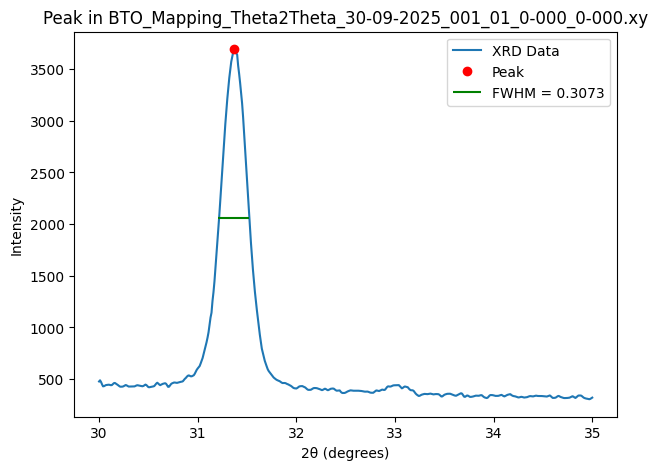

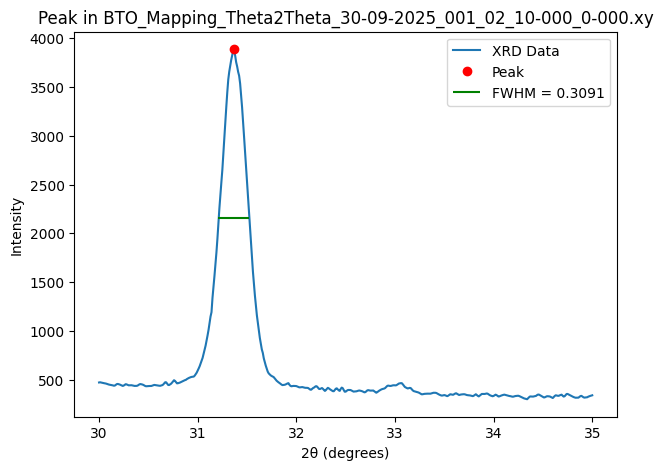

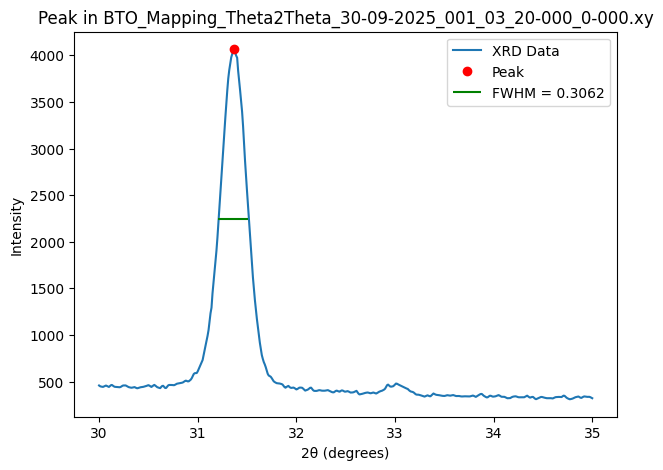

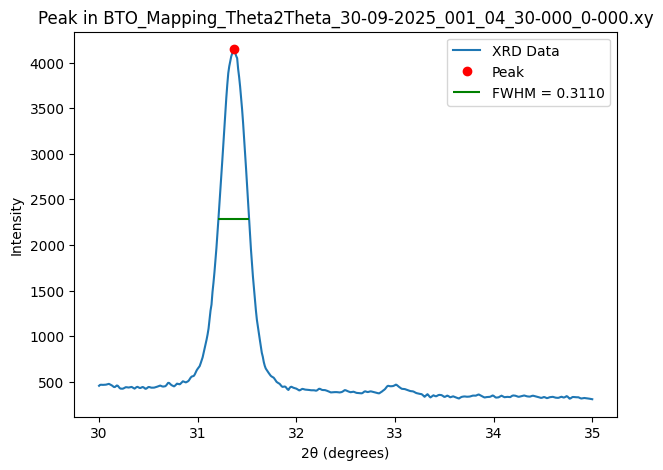

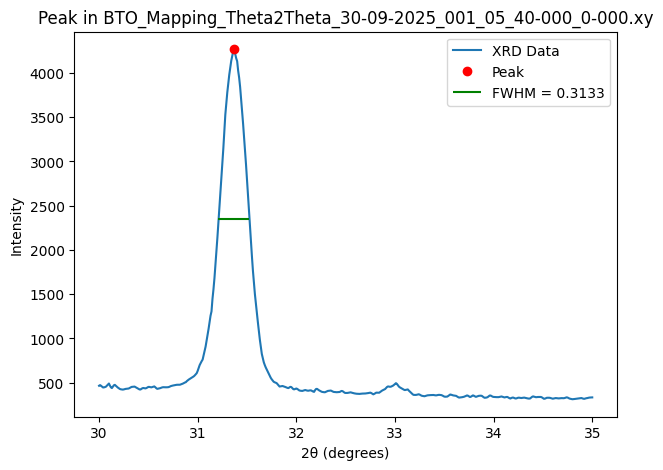

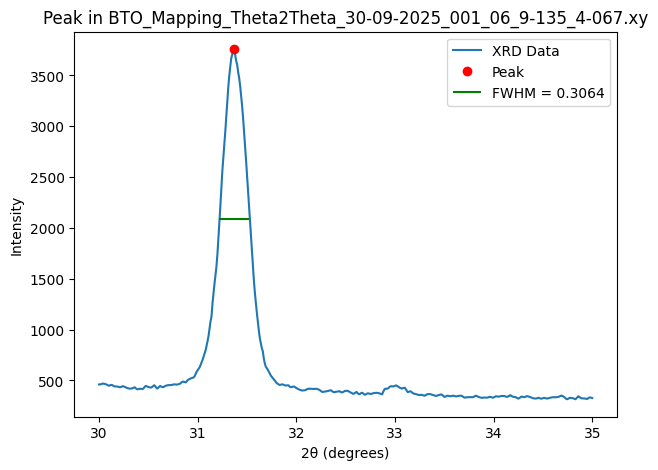

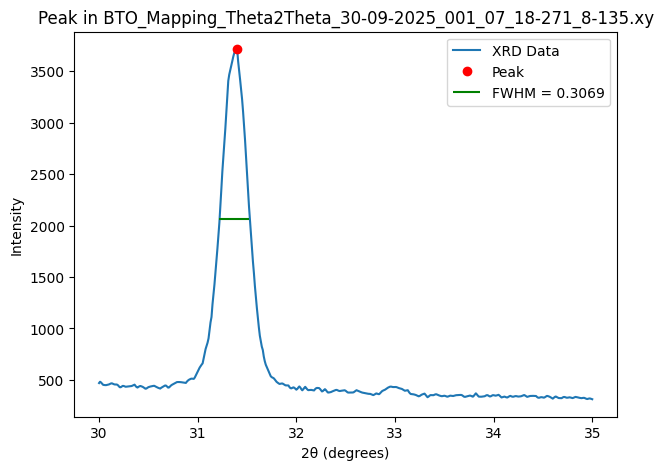

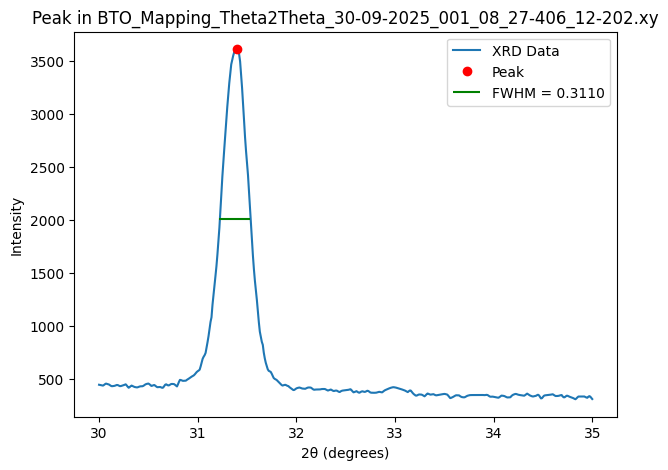

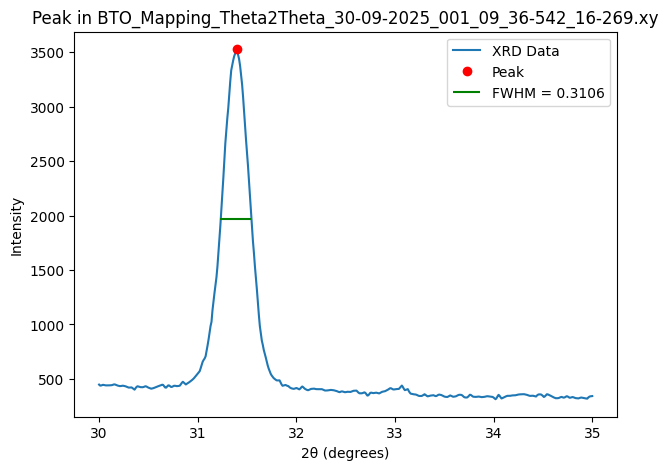

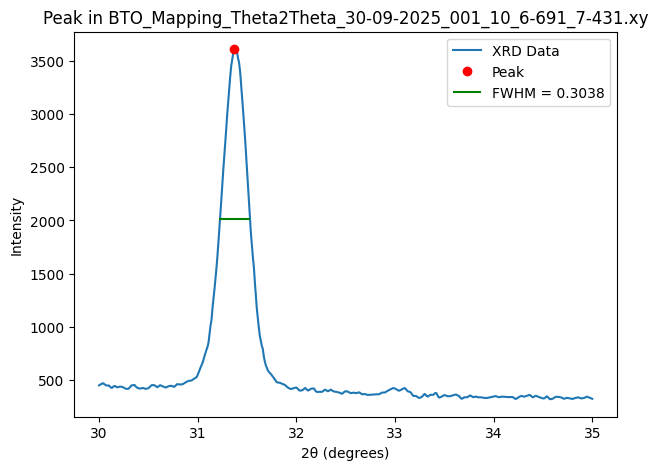

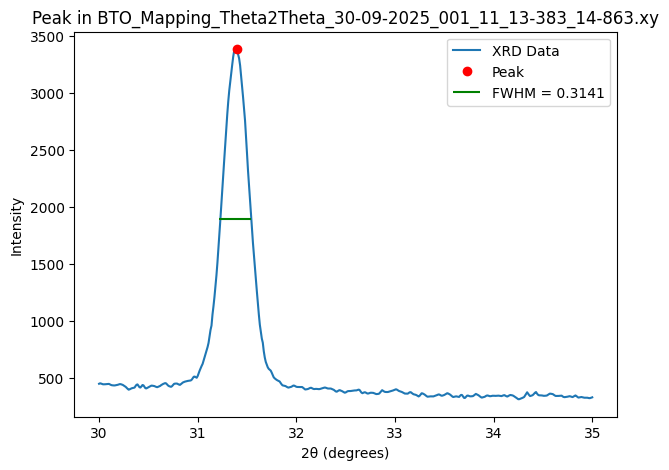

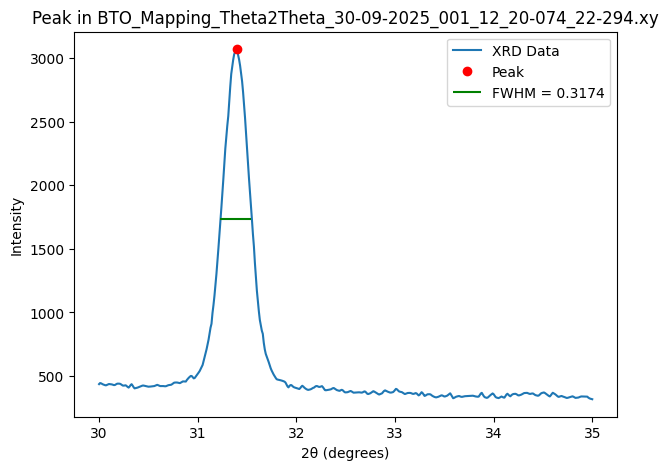

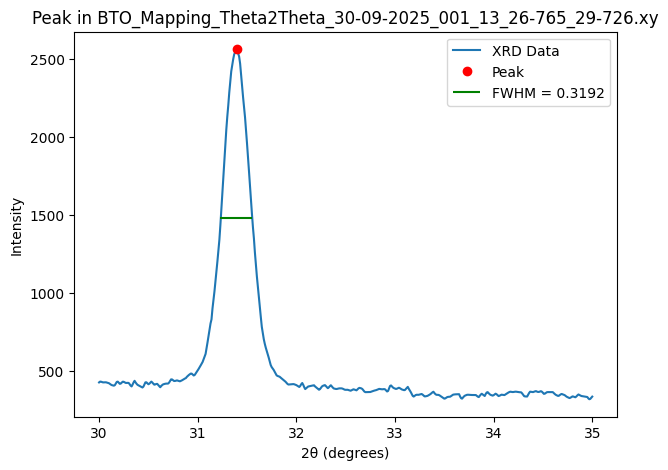

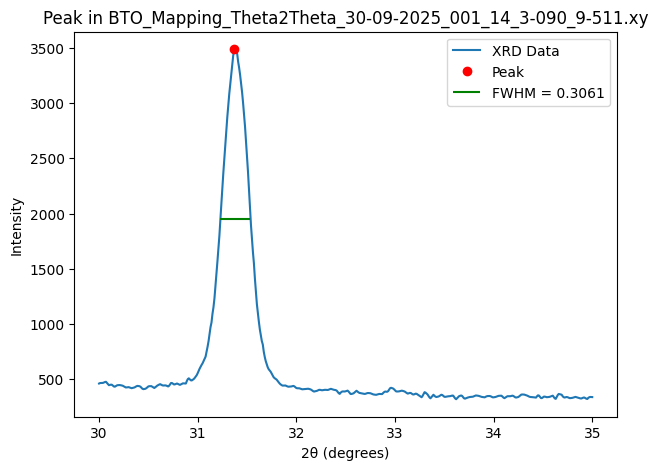

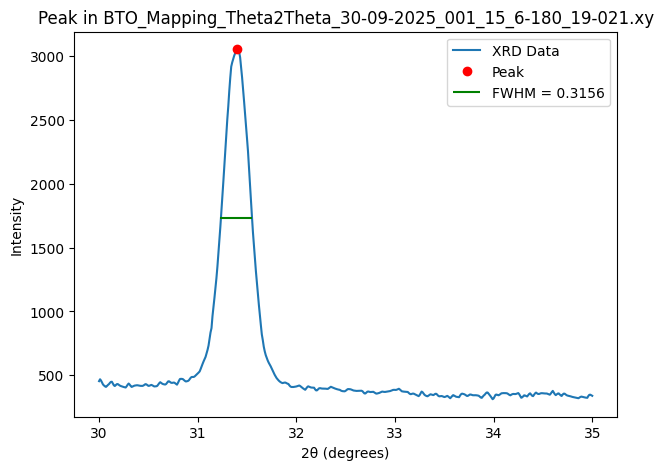

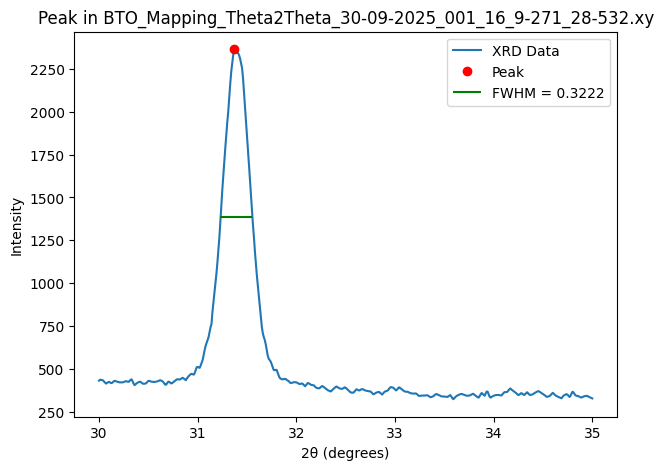

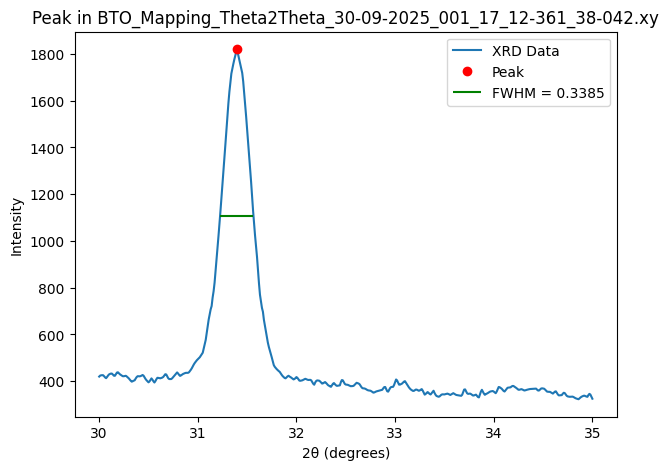

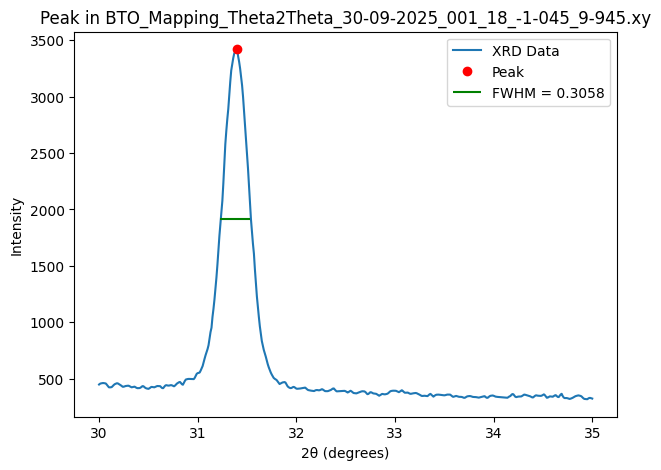

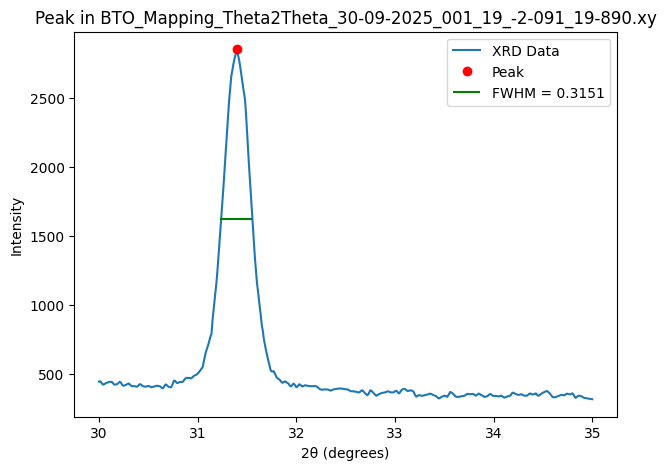

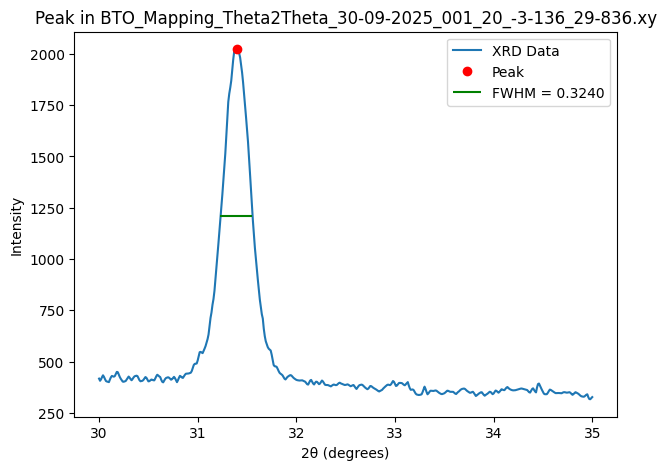

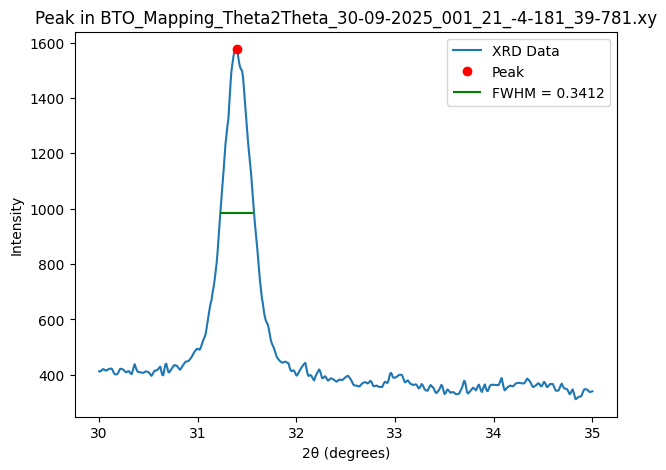

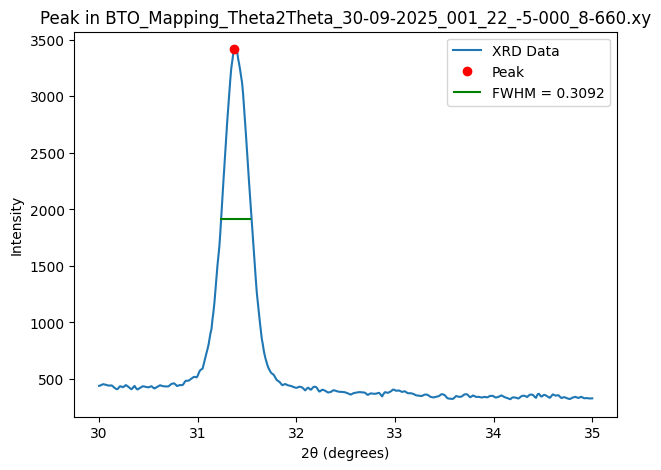

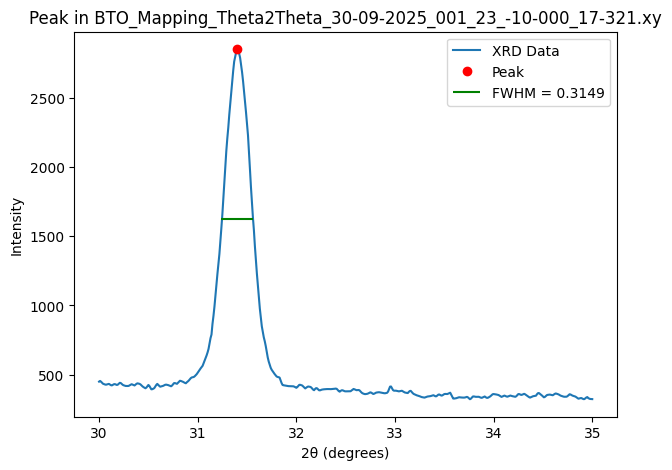

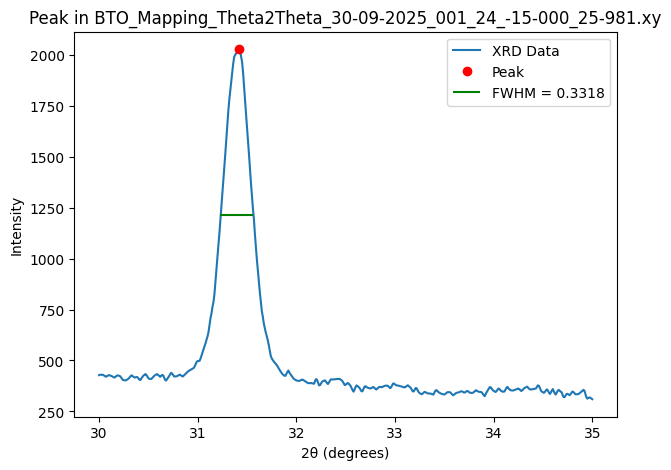

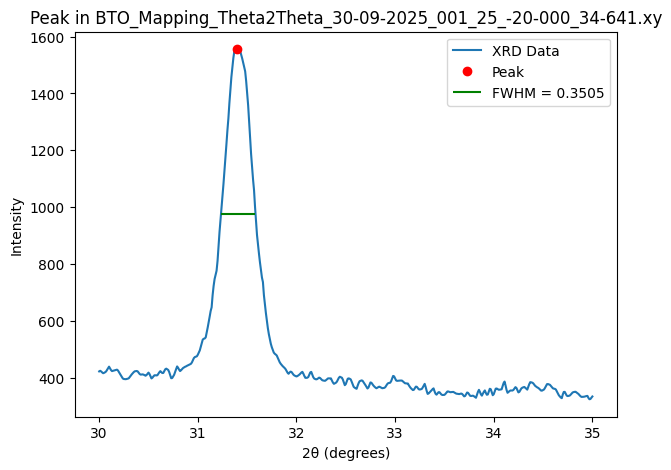

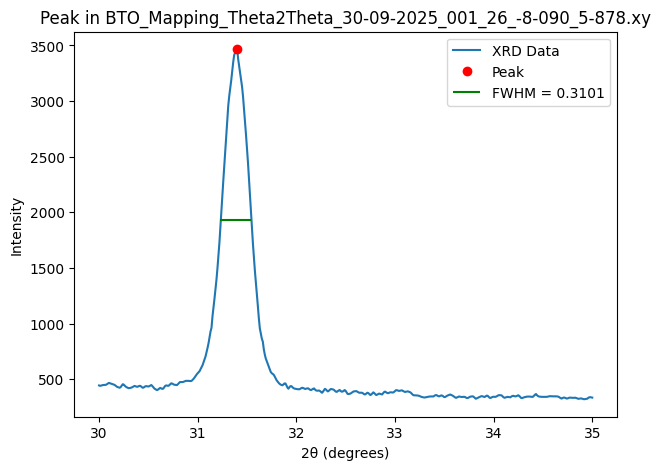

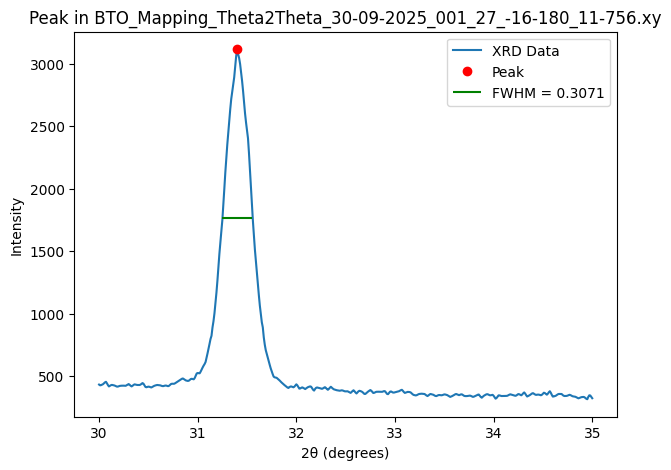

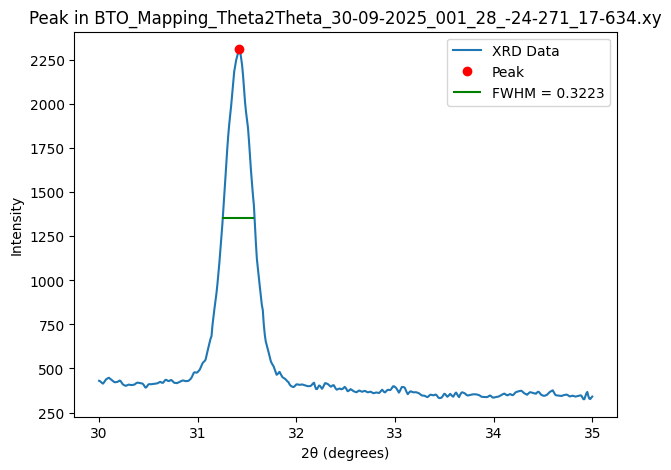

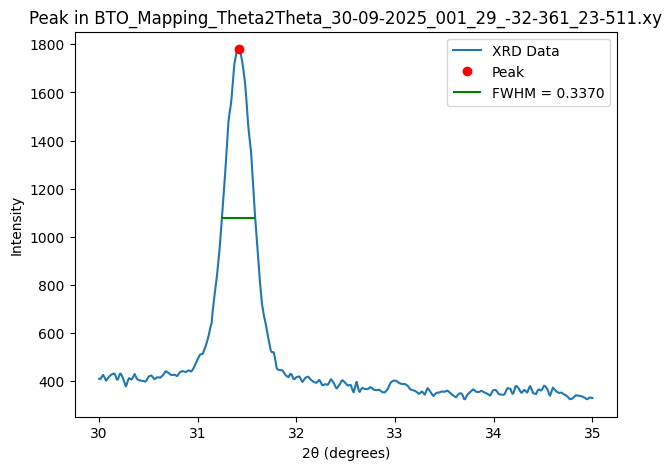

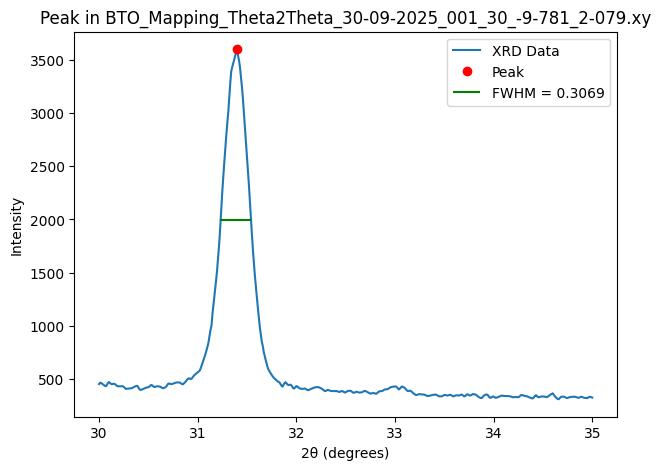

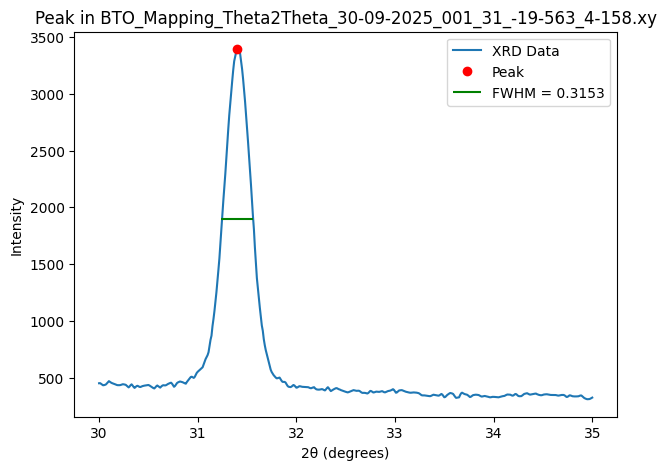

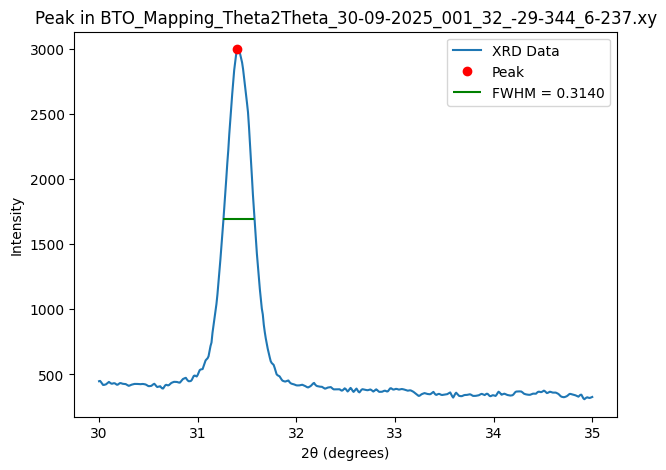

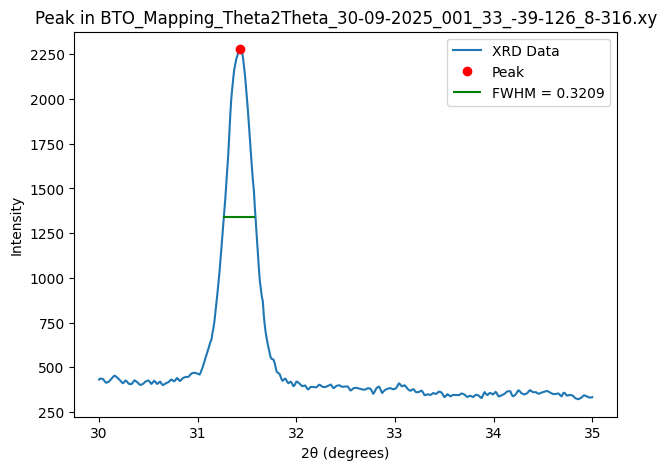

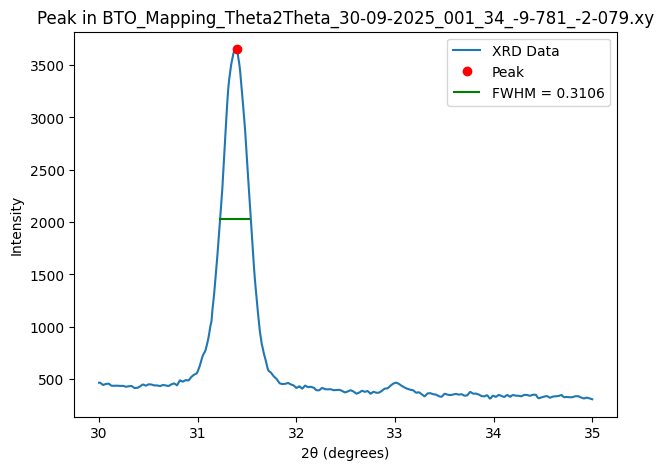

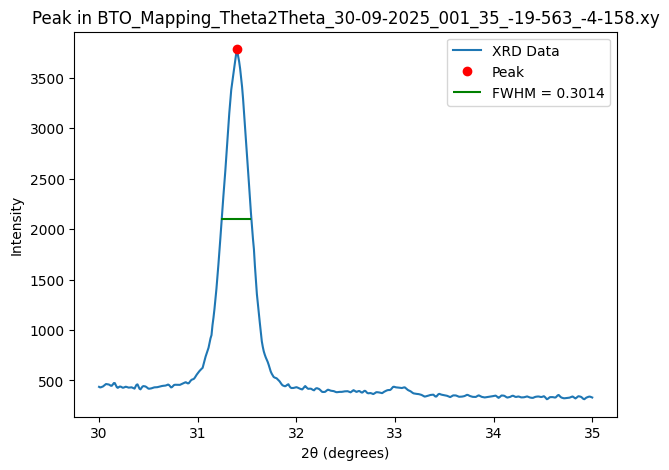

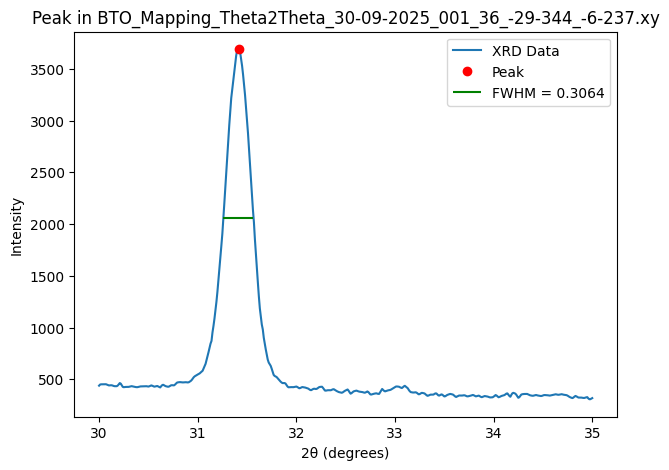

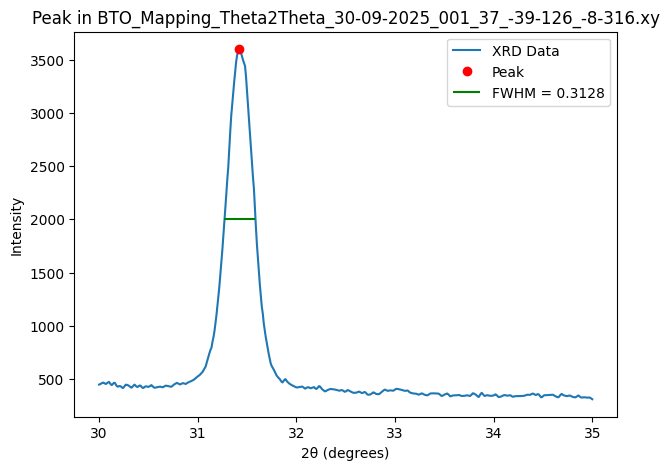

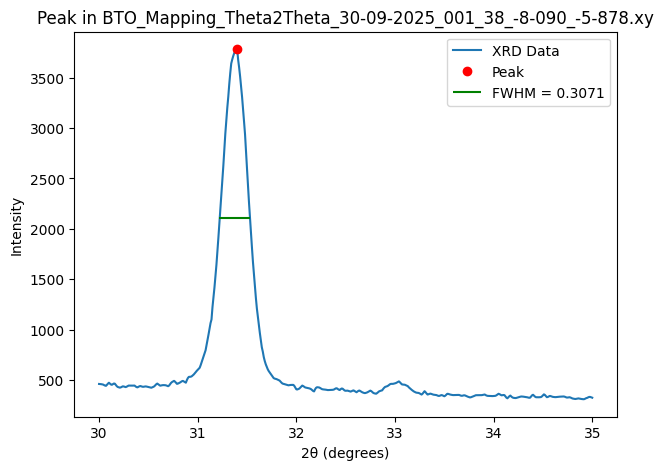

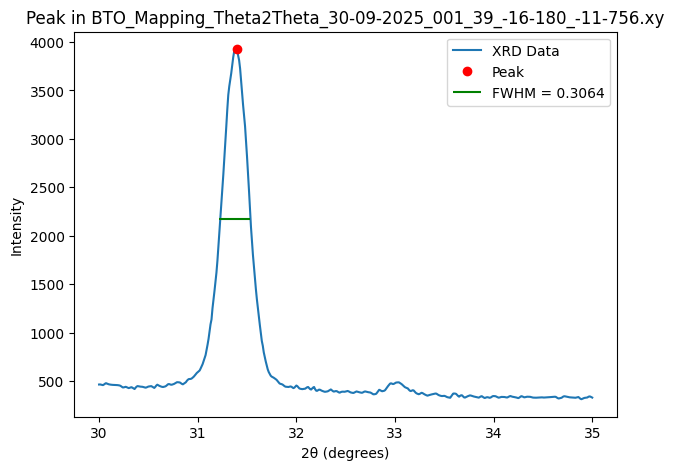

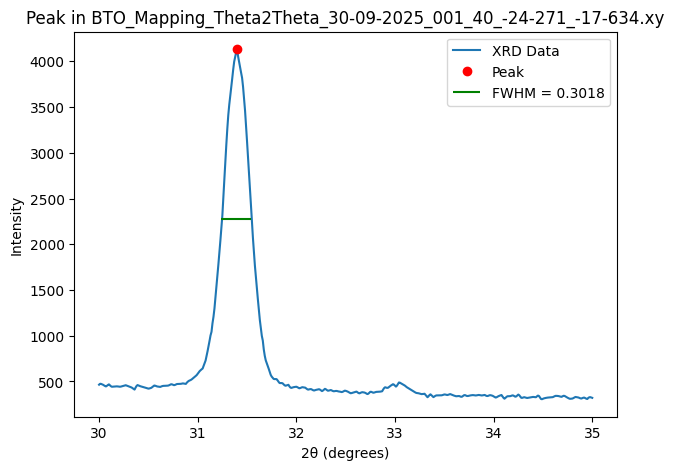

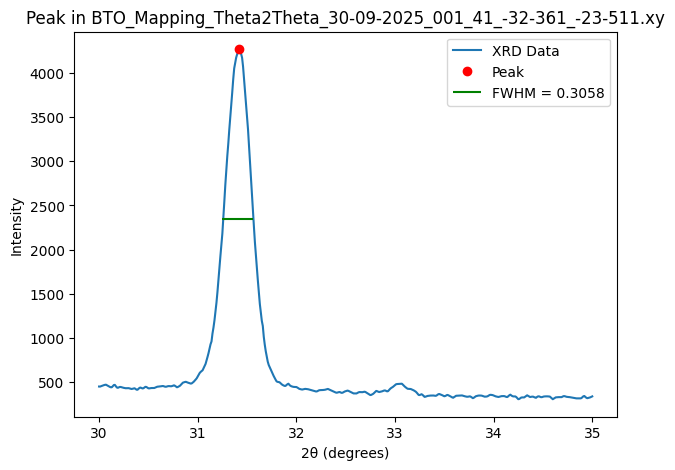

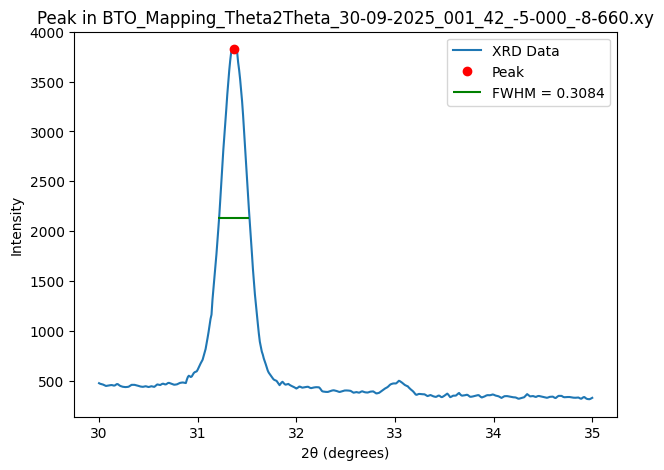

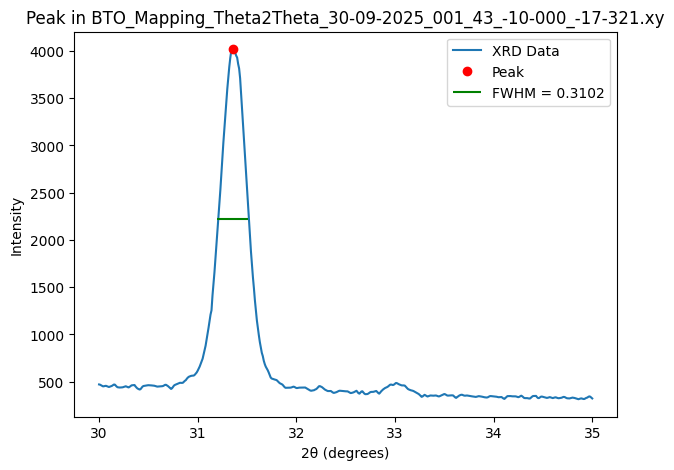

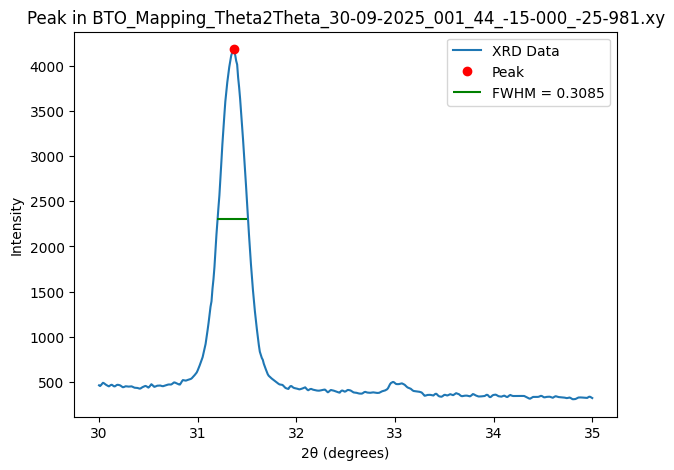

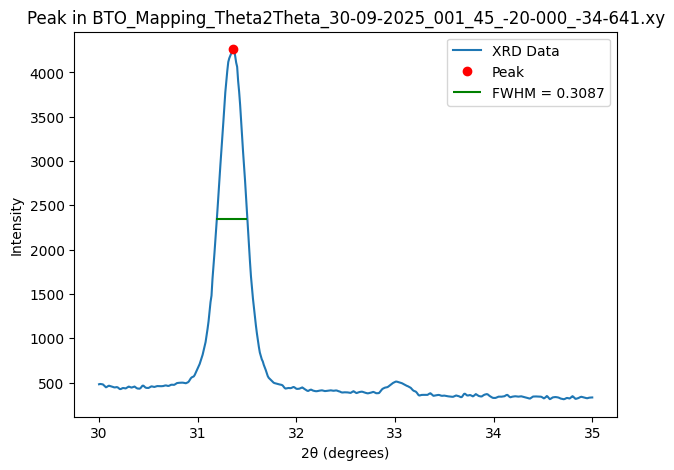

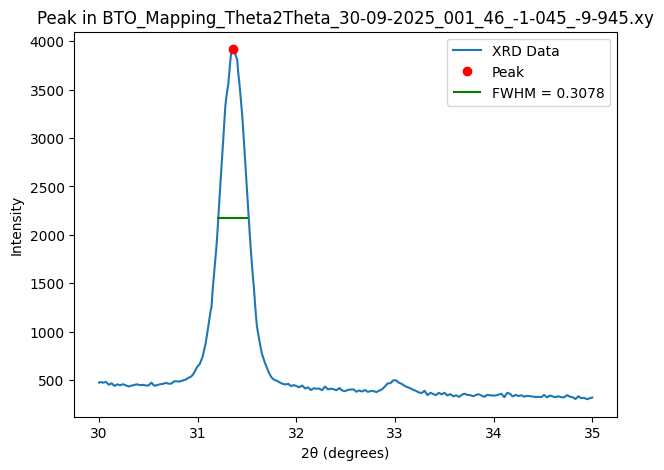

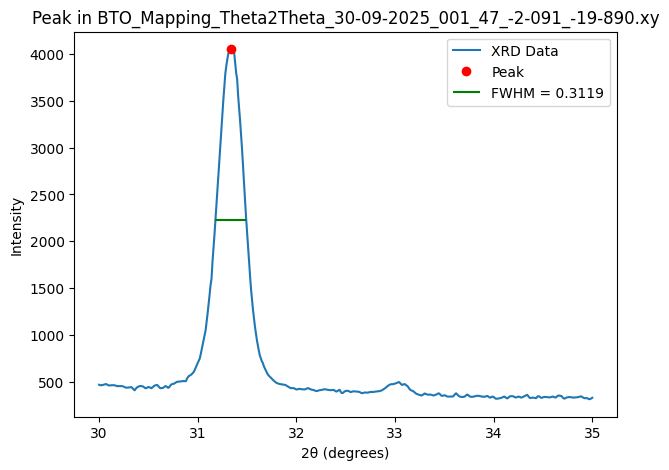

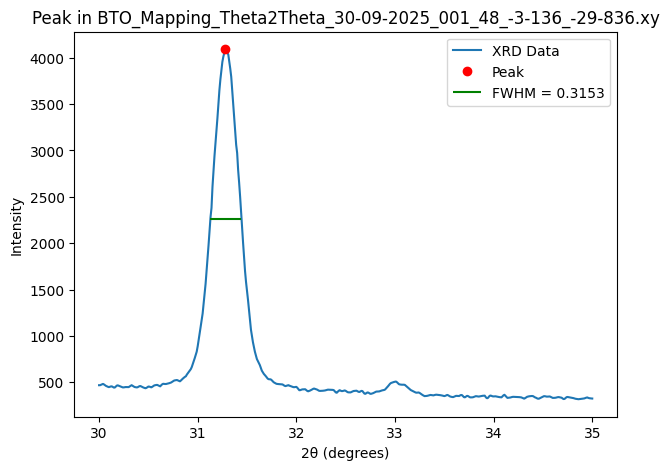

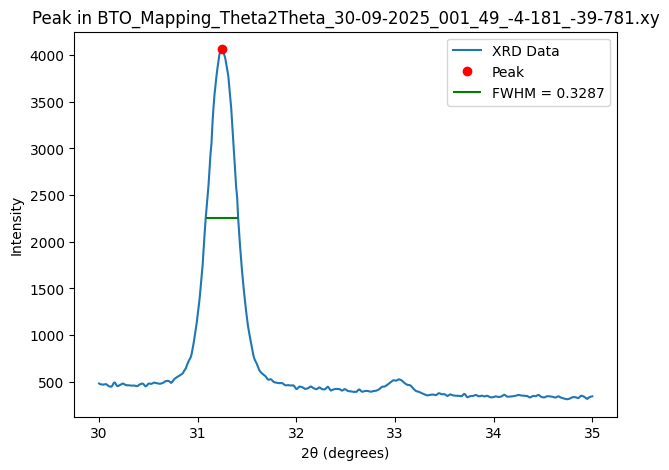

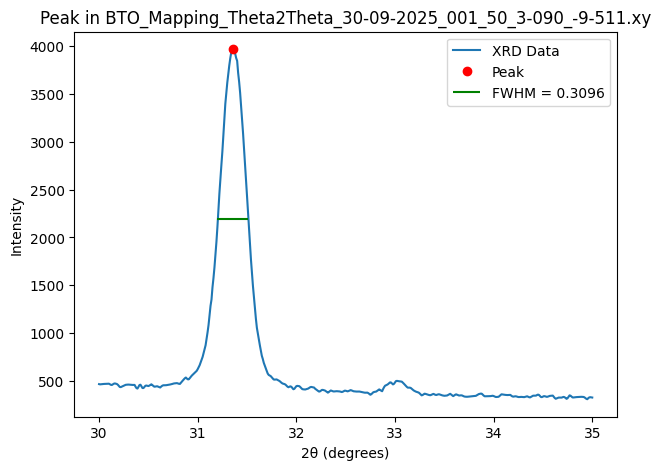

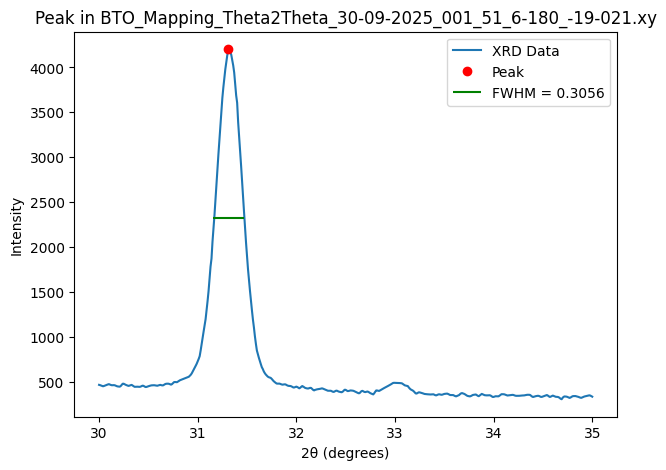

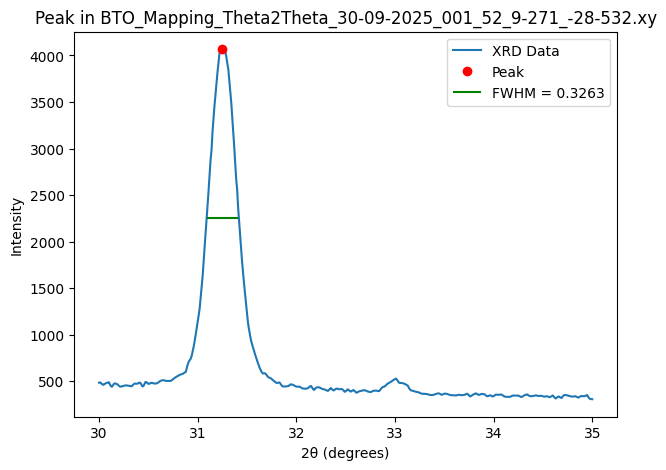

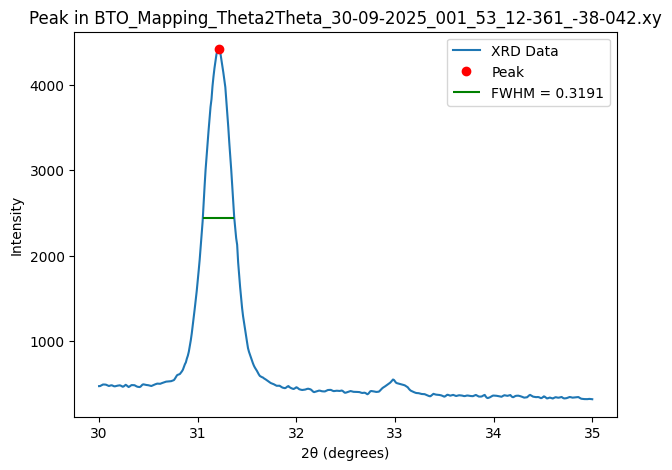

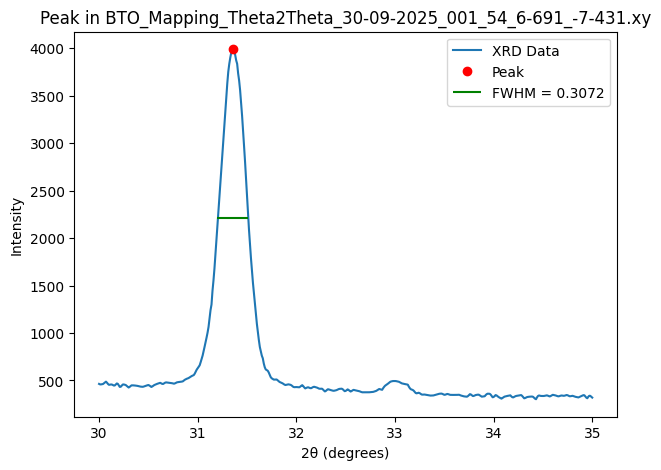

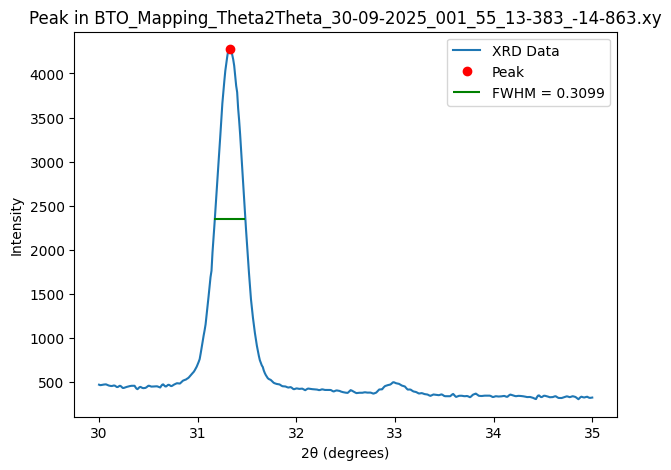

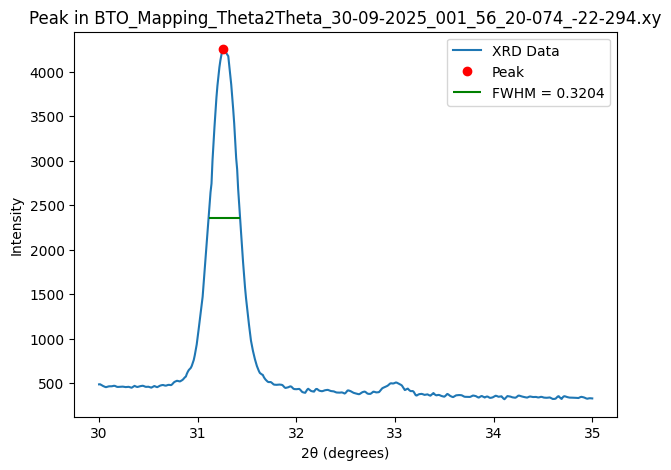

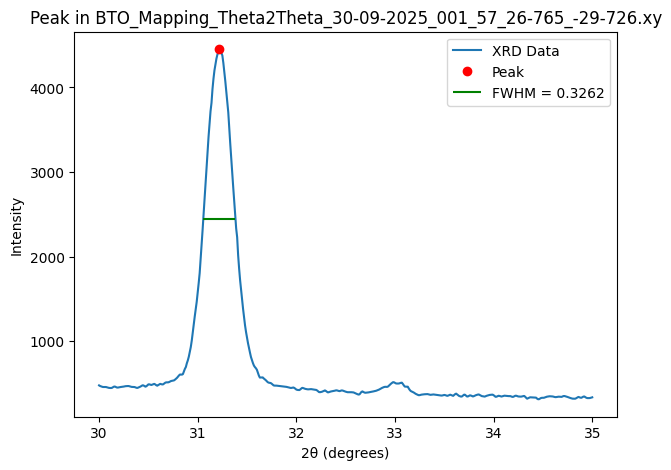

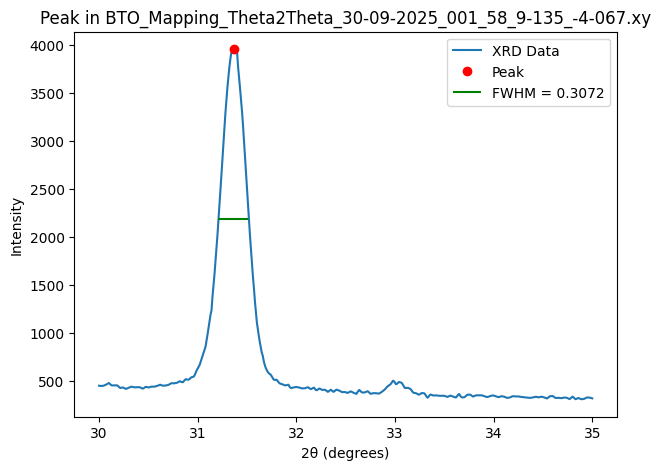

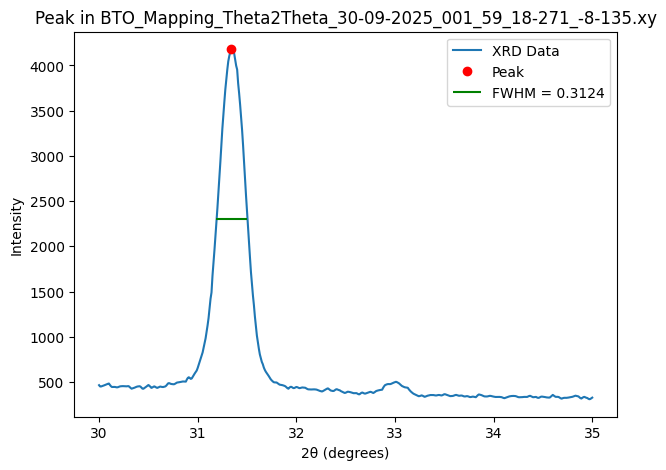

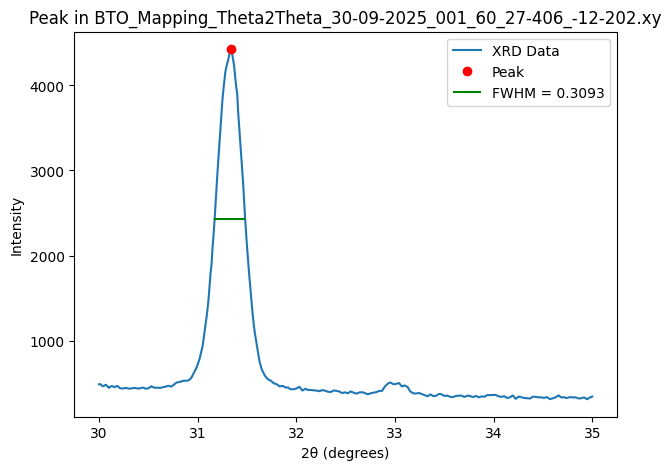

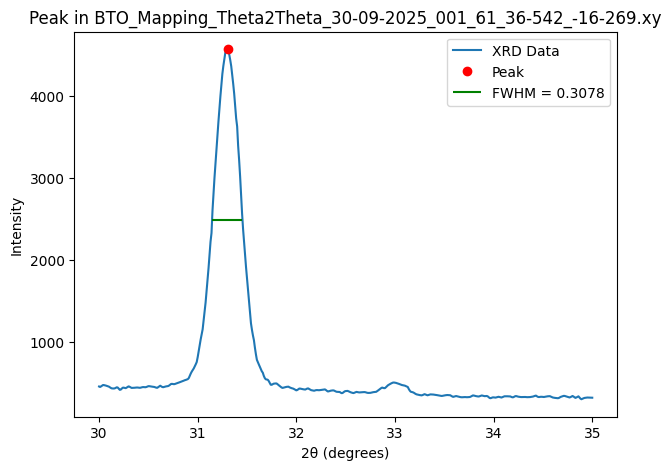

In [4]:
results = []
rejected = []

for f in files:
    # Read file
    df = pd.read_csv(f, delim_whitespace=True, header=None, names=["X", "Y"])
    
    # Region of interest (30–35°)
    roi = df[(df["X"] >= 30) & (df["X"] <= 35)]
    x = roi["X"].values
    y = roi["Y"].values
    
    if len(x) == 0:
        continue  # skip if no data in ROI
    
    # Find peaks
    peaks, _ = find_peaks(y, prominence=0.1)  # adjust prominence if needed
    
    if len(peaks) > 0:
        # Take the most intense peak
        main_peak = peaks[np.argmax(y[peaks])]
        
        # Calculate FWHM
        widths, h_eval, left_ips, right_ips = peak_widths(y, [main_peak], rel_height=0.5)
        
        step_size = x[1] - x[0]  # assumes constant step
        fwhm = widths[0] * step_size
        peak_pos = x[main_peak]

        # --- Filter FWHM range ---
        if 0.1 <= fwhm <= 0.5:
            results.append((f, peak_pos, fwhm))
        
            # --- Plot (optional) ---
            plt.figure(figsize=(7,5))
            plt.plot(x, y, label="XRD Data")
            plt.plot(peak_pos, y[main_peak], "ro", label="Peak")
            plt.hlines(y=h_eval[0], xmin=x[int(left_ips[0])], xmax=x[int(right_ips[0])],
                    color="green", label=f"FWHM = {fwhm:.4f}")
            plt.xlabel("2θ (degrees)")
            plt.ylabel("Intensity")
            plt.title(f"Peak in {f}")
            plt.legend()
            # plt.show()
        elif 0.1 >= fwhm:
            rejected.append((f, peak_pos, fwhm))

# Print summary
# for f, peak, fwhm in results:
#     print(f"{f} -> Peak at {peak:.3f}°, FWHM = {fwhm:.4f}°")

In [5]:
def token_to_float(tok: str) -> float:
    """Convert tokens like '20-000', '-15.500', or '-15-500' to float safely."""
    t = tok.strip()

    # already a normal decimal
    if '.' in t:
        return float(t)

    # handle dash used as decimal separator
    if '-' in t:
        if t.startswith('-'):
            # keep the sign; replace the FIRST remaining '-' with '.'
            body = t[1:].replace('-', '.', 1)
            t = '-' + body
        else:
            # positive number with dash as decimal
            t = t.replace('-', '.', 1)

    return float(t)

def parse_coords_from_name(path: str):
    """Take filename ..._Xcoord_Ycoord.xy (last two underscore tokens) and return floats."""
    name = os.path.splitext(os.path.basename(path))[0]
    x_str, y_str = name.split('_')[-2], name.split('_')[-1]
    return token_to_float(x_str), token_to_float(y_str)

In [6]:
files = glob.glob(os.path.join(folder, "*.xy"))

coords = [parse_coords_from_name(f) for f in files]           # [(x,y), ...]
X, Y = zip(*coords)     

fwhms = [row[2] for row in results]
x_coord = list(X)
y_coord = list(Y)
x_coord = x_coord
y_coord = y_coord
print(type(fwhms[1]), type(X[1]), type(Y), len(fwhms), len(x_coord), len(y_coord), len(rejected), rejected)

<class 'numpy.float64'> <class 'float'> <class 'tuple'> 61 61 61 0 []


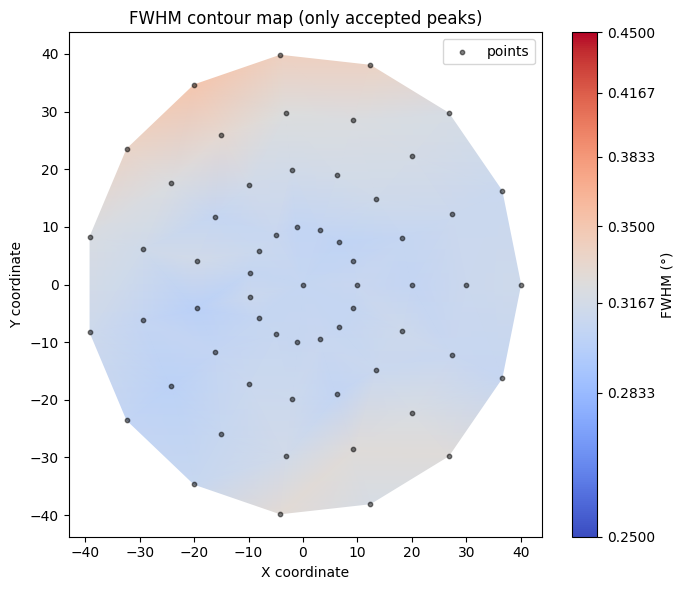

Points: raw=61, after dropna=61, after dedup=61
Z range: 0.3014 → 0.3505


In [7]:
# tri = Triangulation(x_coord, y_coord)
# levels = np.linspace(np.nanmin(fwhms), np.nanmax(fwhms), 50)

# plt.figure(figsize=(7,6))
# cf = plt.tricontourf(tri, fwhms, levels=levels)                # filled contours (optional)
# plt.tricontour(tri, fwhms, levels=levels, linewidths=0.8)      # contour LINES
# plt.scatter(x_coord, y_coord, s=10, c='k', alpha=0.3, label='points')  # show data locations
# plt.colorbar(cf, label="FWHM (°)")
# plt.xlabel("X coordinate")
# plt.ylabel("Y coordinate")
# plt.title("FWHM contour map (triangulated)")
# plt.legend()
# plt.tight_layout()
# plt.show()


# --- helper: convert tokens like '20-000' or '-15-500' to float ---
def token_to_float(tok: str) -> float:
    t = tok.strip()
    if '.' in t:
        return float(t)
    # allow dash as decimal separator once (keep leading minus if present)
    if '-' in t[1:]:
        if t.startswith('-'):
            return float('-' + t[1:].replace('-', '.', 1))
        else:
            return float(t.replace('-', '.', 1))
    return float(t)

# --- build arrays from *accepted* results only ---
# results is expected like: [(filepath, peak_pos, fwhm, snr), ...]
rows = []
for tup in results:
    if len(tup) == 4:
        f, peak_pos, fwhm, snr = tup
    elif len(tup) == 3:
        f, peak_pos, fwhm = tup
    else:
        # unexpected tuple shape; skip
        continue

    name = os.path.basename(f).rsplit('.', 1)[0]
    parts = name.split('_')
    if len(parts) < 2:
        continue
    try:
        x_val = token_to_float(parts[-2])
        y_val = token_to_float(parts[-1])
    except Exception:
        continue

    rows.append((x_val, y_val, float(fwhm)))

df = pd.DataFrame(rows, columns=['x','y','z'])

# --- clean up numeric types and invalids ---
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['z'] = pd.to_numeric(df['z'], errors='coerce')
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
after_dropna = len(df)

# --- average duplicate (x,y) pairs to avoid QHull errors ---
df = df.groupby(['x','y'], as_index=False)['z'].mean()
after_dedup = len(df)

# --- guard: need at least 3 non-colinear points and some z-variation ---
if len(df) < 3:
    raise RuntimeError(f"Not enough valid points for triangulation (have {len(df)}).")

# check variation
zmin, zmax = float(df['z'].min()), float(df['z'].max())
if not np.isfinite(zmin) or not np.isfinite(zmax) or zmin == zmax:
    raise RuntimeError(f"FWHM has no variation (min=max={zmin}); cannot make contour levels.")

# quick colinearity check (both x and y must have some spread)
if df['x'].nunique() < 2 or df['y'].nunique() < 2:
    raise RuntimeError("Points appear colinear or on a single line; triangulation needs 2D spread.")

# --- build arrays ---
x_coord = df['x'].to_numpy(dtype=float)
y_coord = df['y'].to_numpy(dtype=float)
fwhms   = df['z'].to_numpy(dtype=float)

# --- triangulate and plot ---
tri = Triangulation(x_coord, y_coord)
levels = np.linspace(np.nanmin(fwhms), np.nanmax(fwhms), 50)

# High-contrast purple→magenta→orange→yellow map
cmap = LinearSegmentedColormap.from_list(
    "purple2yellow",
    [ "#3b0f70", "#8c2981", "#de4968", "#fca636", "#f0f921"]
)

# Fixed range, with gentle contrast boost near the low end:
norm = PowerNorm(gamma=0.7, vmin=0.25, vmax=0.45)   # use Normalize(...) if you don’t want gamma

plt.figure(figsize=(7,6))
pc = plt.tripcolor(tri, fwhms, shading="gouraud", cmap="coolwarm", norm=norm)  # no lines
plt.scatter(x_coord, y_coord, s=10, c="k", alpha=0.5, label="points")
cbar = plt.colorbar(pc, label="FWHM (°)")
cbar.set_ticks(np.linspace(0.25, 0.45, 7))  # show full 0.2→0.5 bar
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("FWHM contour map (only accepted peaks)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Points: raw={before}, after dropna={after_dropna}, after dedup={after_dedup}")
print(f"Z range: {zmin:.4f} → {zmax:.4f}")


In [8]:
with open("BTO_fwhm_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["X Coordinates", "Y Coordinates", "FWHM"])  # header
    for a, b, c in zip(x_coord, y_coord, fwhms):
        writer.writerow([a, b, c])

In [9]:
# Extract only the FWHM values

fwhm_values = [fwhm for (_, _, fwhm) in results]

if fwhm_values:  # check that the list is not empty
    avg_fwhm = np.mean(fwhm_values)
    print(f"Average FWHM: {avg_fwhm:.4f}°")
else:
    print("No valid FWHM values found in results.")

Average FWHM: 0.3141°
